**Author:** Girwan Dhakal  <br>
**Affiliation:** The University of Alabama, Department of Computer Science <br>
**Date:** 2025-09-23

<hr>

The following notebook analyses speech acts of Late Talking (LT) and Typical Developing (TD) children taken from nine different English corpora from the CHILDES repository.

This notebook analyzes speech acts of late-talking (LT) and typically developing (TD) children across nine English corpora from CHILDES. It integrates datasets, conducts statistical analyses and visualization, and trains supervised models to address the paper’s research goals.


In [1]:
!pip install -q gdown
!pip install childespy

In [2]:
import pandas as pd
import childespy as cpy
from pathlib import Path
import matplotlib.pyplot as plt
import os
import numpy as np
from pathlib import Path
import re
import random
import seaborn as sns


  there is no package called ‘childesr’

(as ‘lib’ is unspecified)



Installing childesr...







	‘/tmp/RtmpnUkx8d/downloaded_packages’



Download the speech act labelled data from direct download links

In [3]:
!gdown "https://drive.google.com/uc?id=14a6ZiOYzgcbiKPJ9ZSnZw2Y2CGze_0Xs"
!gdown "https://drive.google.com/uc?id=14fK6VkYs_g0mav4r4OJ_GPticczXOy3A"
!gdown "https://drive.google.com/uc?id=1B1vKI8MiVD-C8cTWwWsxVfXTGQti9DLh"
!gdown "https://drive.google.com/uc?id=1Bm4KlbY3UYjKl-3qNGwuq1HJUvUT_FDS"
!gdown "https://drive.google.com/uc?id=1LlG-XuA-9fuofRFJGfW4fJMgM46eP9_j"
!gdown "https://drive.google.com/uc?id=1Oe0P0bBE73HspqBLdQfqrsVqhl5jm31V"
!gdown "https://drive.google.com/uc?id=1TitpqtOgexa8OLDITXiaiGdF9sQJUFy0"
!gdown "https://drive.google.com/uc?id=1d_6x4yj0I_gSl_oxedx-fkr2MPEB2ylc"
!gdown "https://drive.google.com/uc?id=1rEVbYlyKYID0uvAKDdnAFdwtwPD1dk_1"
!gdown "https://drive.google.com/uc?id=1u8r4Plj_fSEm8NESEveQO6v1rC05kiXQ"


Downloading...
From: https://drive.google.com/uc?id=14a6ZiOYzgcbiKPJ9ZSnZw2Y2CGze_0Xs
To: /content/UCSD_data_annotated.csv
100% 1.65M/1.65M [00:00<00:00, 42.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=14fK6VkYs_g0mav4r4OJ_GPticczXOy3A
To: /content/EisenbergGuo_data_annotated.csv
100% 1.20M/1.20M [00:00<00:00, 33.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1B1vKI8MiVD-C8cTWwWsxVfXTGQti9DLh
To: /content/ENNI_data_annotated.csv
100% 5.17M/5.17M [00:00<00:00, 195MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Bm4KlbY3UYjKl-3qNGwuq1HJUvUT_FDS
To: /content/Hargrove_data_annotated.csv
100% 747k/747k [00:00<00:00, 67.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1LlG-XuA-9fuofRFJGfW4fJMgM46eP9_j
To: /content/EllisWeismer_data_annotated.csv
100% 20.3M/20.3M [00:00<00:00, 73.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Oe0P0bBE73HspqBLdQfqrsVqhl5jm31V
To: /content/Bliss_data_annotated.csv
100% 495k/495k [00:00<00:00, 18.1MB/s]


In [4]:
corpora = [
    "Bliss",
    "EisenbergGuo",
    "ENNI",
    "Hargrove",
    "Rescorla",
    "UCSD",
    "Conti1",
    "Conti2",
    "Conti3",
    "EllisWeismer",
    "UCSD"
]

os.makedirs("labelled_data", exist_ok=True)
os.makedirs("images", exist_ok = True)
os.makedirs("tables", exist_ok=True)


Downloading datasets and calculating speech act frequencies

## Common Helper Functions

In [5]:

labels = ['21-32 months', '32-45 months', '45-59 months', '59-72 months']

def createLabeledCSV(corpus_name, getLabel):
    """
    Attach diagnostic labels to transcripts in a CHILDES corpus and export a labeled CSV.

    This function retrieves transcript metadata from the specified CHILDES corpus,
    applies a user-defined labeling function to assign binary labels indicating
    speech/language impairment, and merges these labels with an existing annotated
    utterance-level dataset. The result is saved as a labeled CSV file.

    Parameters
    ----------
    corpus_name : str
        The name of the CHILDES corpus (e.g., "Rescorla", "Eisenberg", "EllisWeismer").

    getLabel : Callable
        A function that takes a transcript filename (str) as input and returns an integer label:
        - `1` for speech/language impairment
        - `0` for typical/healthy development

    Returns
    -------
    None
        Writes a new CSV file to `labelled_data/{corpus_name}_annotated_labelled.csv`
        and prints a success message to the console.

    Notes
    -----
    - This function assumes a file named `{corpus_name}_data_annotated.csv` exists
      in the current working directory, containing transcript-level annotations.
    - The output file will include a new `label` column merged with the original data.

    Example
    -------
    >>> def getLabel(filename):
    ...     return 1 if "LT" in filename else 0
    >>> createLabeledCSV("Rescorla", getLabel)
    Successfully created labelled transcript for Rescorla
    """

    # Retrieve transcript metadata using childespy
    transcripts = cpy.get_transcripts(corpus=corpus_name)

    # Assign labels to each transcript using the provided function
    transcripts['label'] = transcripts['filename'].apply(getLabel)

    # Load the existing annotated data (utterance-level)
    final_df = pd.read_csv(f"{corpus_name}_data_annotated.csv")

    # Standardize column name for merging
    transcripts.rename(columns={'transcript_id': 'transcript_file'}, inplace=True)

    # Keep only transcript ID and label
    labels_df = transcripts[['transcript_file', 'label']]

    # Merge labels into the annotated data
    labelled_final_df = pd.merge(labels_df, final_df, on='transcript_file')

    # Save the result
    labelled_final_df.to_csv(f"labelled_data/{corpus_name}_annotated_labelled.csv", index=False)

    print(f"Successfully created labelled transcript for {corpus_name}")


def assignBucket(df):
    """
    Assigns an age-based bucket to each row in the DataFrame.

    Buckets are defined by age in months:
        - [21, 32): Bucket 0
        - [32, 45): Bucket 1
        - [45, 59): Bucket 2
        - [59, 72): Bucket 3

    Parameters
    --------
        df (pd.DataFrame): DataFrame containing a column 'age_months'.

    Returns:
    --------
        pd.DataFrame: Modified DataFrame with a new column 'bucket' indicating the assigned bucket.
    """
    bins = [21,32,45,59,72]
    df['bucket'] = list(pd.cut(df['age_months'], bins=bins, right=False, labels=[0,1,2,3]))
    return df


def assignRandomBucket(l: list):
    """
    Randomly selects a bucket from the given list using a fixed random seed.

    This is used to assign one bucket to an ID that may belong to multiple buckets.

    Parameters:
        l (list): A list of possible bucket labels (integers or strings).

    Returns:
        Any: A randomly selected element from the input list.
    """
    random.seed(42)
    return random.choice(l)


def filterBasedOnBucket(row):
    """
    Determines whether a row belongs in its assigned bucket based on 'age_months'.

    The function checks if the age range matches the assigned bucket label:
        - Bucket 0: [21, 32)
        - Bucket 1: [32, 45)
        - Bucket 2: [45, 59)
        - Bucket 3: [59, 72)

    Parameters
    --------
        row (pd.Series): A row from a DataFrame containing 'age_months' and 'assigned_bucket'.

    Returns
    ------
        bool: True if the row's 'assigned_bucket' matches its age range, False otherwise.
    """
    if 21 <= row['age_months'] < 32 and row['assigned_bucket'] != 0:
        return False
    elif 32 <= row['age_months'] < 45 and row['assigned_bucket'] != 1:
        return False
    elif 45 <= row['age_months'] < 59 and row['assigned_bucket'] != 2:
        return False
    elif 59 <= row['age_months'] < 72 and row['assigned_bucket'] != 3:
        return False
    else:
        return True



## EllisWeismer

### Helper Functions

In [6]:
corpus_name = 'EllisWeismer'
# control : 0, lt/issue : 1, this function basically specifies the rule with which a row is marked as control or clinical
def findLabel(filePath):
  path = Path(filePath)
  parts_of_file = path.parts
  if 'LT' in parts_of_file:
    return 1
  return 0
createLabeledCSV(corpus_name, findLabel)

# creates identifier for each child based on filepath
def getNewId(path: str) -> str:
    file_stem = Path(path).stem

    return file_stem

def infer_sex_from_id(subject_id):
    # Extract numeric part (in case file extension is present)
    digits = ''.join(filter(str.isdigit, str(subject_id)))
    if len(digits) >= 2:
        gender_digit = digits[1]
        if gender_digit == '1':
            return 'female'
        elif gender_digit == '2':
            return 'male'
    return 'unknown'

Successfully created labelled transcript for EllisWeismer


### Data Transformation

In [7]:
file_path = f"labelled_data/{corpus_name}_annotated_labelled.csv"
EllisWeismer = pd.read_csv(file_path)
example = EllisWeismer
# Round ages
EllisWeismer['age_months'] = EllisWeismer['age_months'].round(1)

# Get transcript info
transcripts_df = cpy.get_transcripts(corpus=corpus_name)
transcripts_df['new_id'] = transcripts_df['filename'].apply(getNewId)
transcripts_df = transcripts_df[transcripts_df['target_child_age'] <= 72.0]
transcripts_df = transcripts_df[['transcript_id', 'new_id', 'target_child_sex']]
transcripts_df['target_child_sex'] = transcripts_df['new_id'].apply(infer_sex_from_id)
# Merge into main df
EllisWeismer = pd.merge(EllisWeismer, transcripts_df, how='inner', left_on='transcript_file', right_on='transcript_id').drop(columns=['transcript_id'])
EllisWeismer = EllisWeismer[EllisWeismer['speaker_code'] == 'CHI']

# Assign age buckets
EllisWeismer = assignBucket(EllisWeismer)

# Assign a random bucket per child
grouped = EllisWeismer.groupby('new_id')['bucket'].unique().reset_index().rename(columns={'bucket': 'buckets'})
grouped['assigned_bucket'] = grouped['buckets'].apply(assignRandomBucket)
grouped = grouped.drop(columns=['buckets'])
EllisWeismer = pd.merge(EllisWeismer, grouped, on='new_id')

# Filter rows within the assigned bucket
EllisWeismer['condition'] = EllisWeismer.apply(filterBasedOnBucket, axis=1)
EllisWeismer = EllisWeismer[EllisWeismer['condition'] == True].drop(columns='condition')

#Save transcript mapping per child (drop duplicates)
EllisWeismer_transcript_map = EllisWeismer[['new_id', 'transcript_file']].drop_duplicates().reset_index(drop=True)

# Per-transcript proportion calculation
speech_act_counts = (
    EllisWeismer.groupby(['new_id', 'transcript_file', 'speech_act'])
    .size()
    .reset_index(name='count')
)

total_counts = (
    EllisWeismer.groupby(['new_id', 'transcript_file'])
    .size()
    .reset_index(name='total')
)

merged = pd.merge(speech_act_counts, total_counts, on=['new_id', 'transcript_file'])
merged['proportion'] = merged['count'] / merged['total']

pivot_df = (
    merged.pivot_table(index=['new_id', 'transcript_file'], columns='speech_act', values='proportion', fill_value=0)
    .reset_index()
)

mean_proportions = pivot_df.groupby('new_id').mean(numeric_only=True).reset_index()

labels = EllisWeismer[['new_id', 'label', 'assigned_bucket', 'age_months', 'target_child_sex']].drop_duplicates(subset='new_id')
EllisWeismer = pd.merge(mean_proportions, labels, on='new_id').drop(columns='transcript_file')

### Dataset Stats

In [8]:
stats = {
    'Number of children': EllisWeismer['new_id'].nunique(),
    'Mean age (months)': EllisWeismer['age_months'].mean(),
    'Number of transcripts': EllisWeismer_transcript_map['transcript_file'].nunique(),
    'Sex distribution': EllisWeismer['target_child_sex'].value_counts().to_dict(),
    'Label distribution': EllisWeismer['label'].value_counts().to_dict()
}
for k, v in stats.items():
    print(f"{k}: {v}")


Number of children: 131
Mean age (months): 35.86259541984733
Number of transcripts: 228
Sex distribution: {'male': 78, 'female': 53}
Label distribution: {0: 77, 1: 54}


## Rescorla

### Helper functions

In [9]:
corpus_name = 'Rescorla'
# control : 0, late-talker/issue : 1
def findLabel(filePath):
  path = Path(filePath)
  parts_of_file = path.parts
  if 'LT' in parts_of_file:
    return 1
  return 0
createLabeledCSV(corpus_name, findLabel)

# creates identifier for each child based on filepath
def getNewId(path: str) -> str:
    file_stem = Path(path).stem

    # Match any characters before final 36, 48, or 60
    match = re.match(r"^(.+)(36|48|60)$", file_stem)

    if match:
        return match.group(1)  # everything before 36, 48, or 60

Successfully created labelled transcript for Rescorla


### Data Transformation



In [10]:
file_path = f"labelled_data/{corpus_name}_annotated_labelled.csv"
Rescorla = pd.read_csv(file_path)

#round ages
Rescorla['age_months'] = Rescorla['age_months'].round(1)

# get the transcript information using API
transcripts_df = cpy.get_transcripts(corpus=corpus_name)


# identify each child based on the file name
transcripts_df['new_id'] = transcripts_df['filename'].apply(getNewId)

# transcripts_df['has_gr36'] = transcripts_df['filename'].apply(
#     lambda x: 'tan48' in Path(x).stem or 'tan36' in Path(x).stem or 'tan60' in Path(x).stem
# )

# # To print only matching rows
# print(transcripts_df[transcripts_df['has_gr36']])
# transcripts_df = transcripts_df.drop(columns='has_gr36')

#transcripts 32949 32950
#merging gr36a and gr36b into one single
transcripts_df.loc[transcripts_df['transcript_id'] == 32949, "new_id"] = 'gr'
transcripts_df.loc[transcripts_df['transcript_id'] == 32950, "new_id"] = 'gr'

# filter for samples with age less than 72 months (6 years)
transcripts_df = transcripts_df[transcripts_df['target_child_age'] <= 72.0]
transcripts_df = transcripts_df[['transcript_id', 'new_id', 'target_child_sex']]

# merge with main dataframe to add the identifier column
Rescorla = pd.merge(Rescorla, transcripts_df, how='inner', left_on='transcript_file', right_on='transcript_id').drop(columns=['transcript_id'])

# keep only the 'CHI' utterances
Rescorla = Rescorla[Rescorla['speaker_code'] == 'CHI']

# assign buckets to each row
Rescorla = assignBucket(Rescorla)

# Group the DataFrame by 'new_id', extract unique values from the 'bucket' column for each group
grouped = Rescorla.groupby('new_id')['bucket'].unique().reset_index().rename(columns={'bucket':'buckets'})

# print(grouped.head())

# apply the assignRandomBucket function to each row, thus associating each id with a bucket number
grouped['assigned_bucket'] = grouped['buckets'].apply(assignRandomBucket)

# drop unnecessary column
grouped = grouped.drop(columns=['buckets'])

# merge back with main dataframe
Rescorla = pd.merge(Rescorla, grouped, on='new_id').drop(columns='bucket')

# remove rows that we did not select after doing random sample of the buckets
Rescorla['condition'] = Rescorla.apply(filterBasedOnBucket, axis=1 )
Rescorla = Rescorla[Rescorla['condition'] == True].drop(columns='condition')


# Count speech acts per transcript
speech_act_counts = (
    Rescorla.groupby(['new_id', 'transcript_file', 'speech_act'])
    .size()
    .reset_index(name='count')
)

# Count total utterances per transcript
total_counts = (
    Rescorla.groupby(['new_id', 'transcript_file'])
    .size()
    .reset_index(name='total')
)

# Merge and compute proportion per transcript
merged = pd.merge(speech_act_counts, total_counts, on=['new_id', 'transcript_file'])
merged['proportion'] = merged['count'] / merged['total']

# Pivot to wide format at transcript level
pivot_df = (
    merged.pivot_table(index=['new_id', 'transcript_file'], columns='speech_act', values='proportion', fill_value=0)
    .reset_index()
)

# Create transcript map (which transcripts were used per child)
Rescorla_transcript_map = Rescorla[['new_id', 'transcript_file']].drop_duplicates().reset_index(drop=True)

# Average across transcripts per child
mean_proportions = pivot_df.groupby('new_id').mean(numeric_only=True).reset_index()

# Add label column (assuming one label per new_id)
labels = Rescorla[['new_id', 'label','age_months','assigned_bucket','target_child_sex']].drop_duplicates(subset='new_id')

# Final merge
Rescorla = pd.merge(mean_proportions, labels, on='new_id').drop(columns='transcript_file')

Rescorla

,new_id,AA,AB,AC,AD,AN,AP,CL,CM,CN,...,TX,WD,XA,YD,YQ,YY,label,age_months,assigned_bucket,target_child_sex
0,aik,0.038462,0.0,0.023077,0.023077,0.015385,0.015385,0.015385,0.0,0.0,...,0.007692,0.0,0.000000,0.000000,0.000000,0.246154,0,60.0,3,female
1,ale,0.046053,0.0,0.026316,0.026316,0.013158,0.000000,0.000000,0.0,0.0,...,0.000000,0.0,0.006579,0.000000,0.000000,0.236842,1,60.0,3,female
2,ant,0.038760,0.0,0.000000,0.015504,0.000000,0.007752,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.155039,0,36.0,1,female
3,axl,0.025157,0.0,0.018868,0.018868,0.000000,0.018868,0.006289,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.194969,0,36.0,1,female
4,ban,0.055556,0.0,0.020833,0.013889,0.000000,0.020833,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.006944,0.000000,0.180556,1,60.0,3,female
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,sul,0.055118,0.0,0.015748,0.000000,0.007874,0.007874,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.007874,0.157480,1,60.0,3,female
61,tan,0.039474,0.0,0.013158,0.019737,0.000000,0.006579,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.006579,0.000000,0.289474,0,60.0,3,female
62,tro,0.025641,0.0,0.017094,0.059829,0.000000,0.017094,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.273504,0,36.0,1,female
63,wal,0.014184,0.0,0.042553,0.049645,0.007092,0.007092,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.156028,0,60.0,3,female


### Dataset Stats

In [11]:
stats = {
    'Number of children': Rescorla['new_id'].nunique(),
    'Mean age (months)': Rescorla['age_months'].mean(),
    'Number of transcripts': transcripts_df['transcript_id'].nunique(),
    'Sex distribution': Rescorla['target_child_sex'].value_counts().to_dict(),
    'Label distribution': Rescorla['label'].value_counts().to_dict()
}
for k, v in stats.items():
    print(f"{k}: {v}")


Number of children: 65
Mean age (months): 52.44615384615385
Number of transcripts: 145
Sex distribution: {'female': 54, 'male': 11}
Label distribution: {1: 39, 0: 26}


## EisenbergGuo

### Helper Functions

In [12]:
# sex data
! gdown https://drive.google.com/uc?id=1b5C46T5tj4dHzQLpIe5s5w8teBsMEseQ

corpus_name = 'EisenbergGuo'
transcripts = cpy.get_transcripts(corpus=corpus_name)
# control : 0, late-talker/issue : 1
def findLabel(filePath):
  path = Path(filePath)
  parts_of_file = path.parts
  if 'SLI' in parts_of_file:
    return 1
  return 0

createLabeledCSV(corpus_name, findLabel)

def getNewId(path):
  # the file stem will be the unique identifier for each sample
  return Path(path).stem


Downloading...
From: https://drive.google.com/uc?id=1b5C46T5tj4dHzQLpIe5s5w8teBsMEseQ
To: /content/Eisenberg_target_child_sex.csv
100% 434/434 [00:00<00:00, 2.18MB/s]


Successfully created labelled transcript for EisenbergGuo


### Data Transformation

In [13]:
file_path = f"labelled_data/{corpus_name}_annotated_labelled.csv"
Eisenberg = pd.read_csv(file_path)

# Round the age and assign bucket
Eisenberg['age_months'] = Eisenberg['age_months'].round(1)
Eisenberg = assignBucket(Eisenberg)

# Get transcript metadata
transcripts_df = cpy.get_transcripts(corpus=corpus_name)
transcripts_df['new_id'] = transcripts_df['filename'].apply(getNewId)

# Filter out transcripts with age > 72 months
transcripts_df = transcripts_df[transcripts_df['target_child_age'] <= 72.0]
transcripts_df = transcripts_df[['transcript_id', 'new_id', 'target_child_sex']]


# Merge with main data to add new_id and target_child_sex
Eisenberg = pd.merge(Eisenberg, transcripts_df, how='inner', left_on='transcript_file', right_on='transcript_id').drop(columns=['transcript_id'])

# Count speech acts per transcript
speech_act_counts = (
    Eisenberg.groupby(['new_id', 'transcript_file', 'speech_act'])
    .size()
    .reset_index(name='count')
)

# Count total utterances per transcript
total_counts = (
    Eisenberg.groupby(['new_id', 'transcript_file'])
    .size()
    .reset_index(name='total')
)

# Merge and compute proportion per transcript
merged = pd.merge(speech_act_counts, total_counts, on=['new_id', 'transcript_file'])
merged['proportion'] = merged['count'] / merged['total']

# Pivot to wide format at transcript level
pivot_df = (
    merged.pivot_table(index=['new_id', 'transcript_file'], columns='speech_act', values='proportion', fill_value=0)
    .reset_index()
)

# Create transcript map (which transcripts were used per child)
Eisenberg_transcript_map = Eisenberg[['new_id', 'transcript_file']].drop_duplicates().reset_index(drop=True)

# Average across transcripts per child
mean_proportions = pivot_df.groupby('new_id').mean(numeric_only=True).reset_index()

# Add label and demographic metadata
labels = Eisenberg[['new_id', 'label', 'bucket', 'age_months', 'target_child_sex']].drop_duplicates(subset='new_id')

# Read the excel sheet containing specially parsed sex data for EisenbergGuo

Eisenberg_sex_data = pd.read_csv('Eisenberg_target_child_sex.csv')


# Final merge
Eisenberg = pd.merge(mean_proportions, labels, on='new_id').rename(columns={'bucket': 'assigned_bucket'})

# Merge the sex data, drop missing values and
Eisenberg = pd.merge(Eisenberg, Eisenberg_sex_data,how='inner', left_on='new_id', right_on='ID').dropna().drop(columns=['target_child_sex', 'ID']).rename(columns={'Sex':'target_child_sex'})

# Get the child-transcript mappings for this dataset
Eisenberg_transcript_map = Eisenberg[['new_id', 'transcript_file']].drop_duplicates().reset_index(drop=True)

Eisenberg = Eisenberg.drop(columns='transcript_file')


### Dataset Stats

In [14]:
stats = {
    'Number of children': Eisenberg['new_id'].nunique(),
    'Mean age (months)': Eisenberg['age_months'].mean(),
    'Number of transcripts': Eisenberg_transcript_map['transcript_file'].nunique(),
    'Sex distribution': Eisenberg['target_child_sex'].value_counts().to_dict(),
    'Label distribution': Eisenberg['label'].value_counts().to_dict()
}

for k, v in stats.items():
    print(f"{k}: {v}")

Number of children: 32
Mean age (months): 41.25
Number of transcripts: 32
Sex distribution: {'male': 19, 'female': 13}
Label distribution: {0: 17, 1: 15}


## ENNI

### Helper Functions

In [15]:

# Download the participant data because the API is not giving correct results
!gdown https://drive.google.com/uc?id=1NhZx3daUKBCLEYf9zJusf5sYf1FjJb9S -O ENNI_sex_data.xls


corpus_name = 'ENNI'
transcripts = cpy.get_transcripts(corpus=corpus_name)
# control : 0, late-talker/issue : 1
def findLabel(filePath):
  path = Path(filePath)
  parts_of_file = path.parts
  if 'SLI' in parts_of_file:
    return 1
  return 0

createLabeledCSV(corpus_name, findLabel)

def getNewId(path):
  # the file stem will be the unique identifier for each sample
  return Path(path).stem

Downloading...
From: https://drive.google.com/uc?id=1NhZx3daUKBCLEYf9zJusf5sYf1FjJb9S
To: /content/ENNI_sex_data.xls
100% 38.4k/38.4k [00:00<00:00, 65.3MB/s]


Successfully created labelled transcript for ENNI


### Data Transformation

In [16]:
file_path = f"labelled_data/{corpus_name}_annotated_labelled.csv"
ENNI = pd.read_csv(file_path)

# Round age and assign bucket
ENNI['age_months'] = ENNI['age_months'].round(1)
ENNI = assignBucket(ENNI)

# Get transcript metadata
transcripts_df = cpy.get_transcripts(corpus=corpus_name)
transcripts_df['new_id'] = transcripts_df['filename'].apply(getNewId)

# Filter out transcripts over 72 months
transcripts_df = transcripts_df[transcripts_df['target_child_age'] <= 72.0]
transcripts_df = transcripts_df[['transcript_id', 'new_id']]

# Infer sex from child ID (based on 2nd digit rule)
def infer_sex_from_id(new_id):
    digits = ''.join(filter(str.isdigit, str(new_id)))
    if len(digits) >= 2:
        return 'female' if digits[1] == '1' else 'male'
    return 'unknown'

transcripts_df['target_child_sex'] = transcripts_df['new_id'].apply(infer_sex_from_id)

# Merge metadata into main dataframe
ENNI = pd.merge(ENNI, transcripts_df, how='inner', left_on='transcript_file', right_on='transcript_id').drop(columns=['transcript_id'])

# Count speech acts per transcript
speech_act_counts = (
    ENNI.groupby(['new_id', 'transcript_file', 'speech_act'])
    .size()
    .reset_index(name='count')
)

# Count total utterances per transcript
total_counts = (
    ENNI.groupby(['new_id', 'transcript_file'])
    .size()
    .reset_index(name='total')
)

# Compute proportion per speech act in each transcript
merged = pd.merge(speech_act_counts, total_counts, on=['new_id', 'transcript_file'])
merged['proportion'] = merged['count'] / merged['total']

# Pivot to wide format per transcript
pivot_df = (
    merged.pivot_table(index=['new_id', 'transcript_file'], columns='speech_act', values='proportion', fill_value=0)
    .reset_index()
)

# Create transcript map for transparency
ENNI_transcript_map = ENNI[['new_id', 'transcript_file']].drop_duplicates().reset_index(drop=True)

# Average speech act proportions across transcripts per child
mean_proportions = pivot_df.groupby('new_id').mean(numeric_only=True).reset_index().drop(columns='transcript_file')

# Merge in labels and demographics
labels = ENNI[['new_id', 'label', 'age_months', 'bucket', 'target_child_sex']].drop_duplicates(subset='new_id')

# Final dataset
ENNI = pd.merge(mean_proportions, labels, on='new_id').rename(columns={'bucket': 'assigned_bucket'})

# Read the sex data from excel file
ENNI_sex_data = pd.read_excel("/content/ENNI_sex_data.xls").drop(columns='age')
ENNI_sex_data['ID'] = ENNI_sex_data['ID'].astype(str)

ENNI = pd.merge(ENNI, ENNI_sex_data, how='inner', left_on='new_id', right_on='ID').drop(columns=['target_child_sex', 'ID']).rename(columns={'sex':'target_child_sex'})
ENNI['target_child_sex'] = ENNI['target_child_sex'].map({'M':'male', 'F':'female'})

### Dataset Stats

In [17]:
stats = {
    'Number of children': ENNI['new_id'].nunique(),
    'Mean age (months)': ENNI['age_months'].mean(),
    # 'Number of transcripts': ENNI['transcript_file'].nunique(),
    'Sex distribution': ENNI['target_child_sex'].value_counts().to_dict(),
    'Label distribution': ENNI['label'].value_counts().to_dict()
}

# Print nicely
for k, v in stats.items():
    print(f"{k}: {v}")

Number of children: 126
Mean age (months): 60.64126984126984
Sex distribution: {'male': 67, 'female': 59}
Label distribution: {0: 100, 1: 26}


## Bliss

This is a cross-sectional dataset

### Helper Functions

In [18]:
corpus_name = 'Bliss'
transcripts = cpy.get_transcripts(corpus=corpus_name)
# control : 0, late-talker/issue : 1
def findLabel(filePath):
  path = Path(filePath)
  parts_of_file = path.parts
  if 'Clinical-MOR' in parts_of_file:
    return 1
  return 0

createLabeledCSV(corpus_name, findLabel)

def getNewId(path):
  # the file stem will be the unique identifier for each sample
  return Path(path).stem


Successfully created labelled transcript for Bliss


### Data Transformation

Add the unique identifiers

In [19]:
file_path = f"labelled_data/{corpus_name}_annotated_labelled.csv"
Bliss = pd.read_csv(file_path)

# Round age
Bliss['age_months'] = Bliss['age_months'].round(1)

#Assign bucket
Bliss = assignBucket(Bliss)

# Get transcript metadata
transcripts_df = cpy.get_transcripts(corpus=corpus_name)

# create identifier based on file name
transcripts_df['new_id'] = transcripts_df['filename'].apply(getNewId)

# filter based on age
transcripts_df = transcripts_df[transcripts_df['target_child_age'] <= 72.0]

# filter features
transcripts_df = transcripts_df[['transcript_id', 'new_id', 'target_child_sex']]

# Merge transcript data into main dataframe
Bliss = pd.merge(Bliss, transcripts_df, how='inner', left_on='transcript_file', right_on='transcript_id').drop(columns=['transcript_id'])

# Create transcript map
Bliss_transcript_map = Bliss[['new_id', 'transcript_file']].drop_duplicates().reset_index(drop=True)

# Compute speech act proportions per transcript
speech_act_counts = (
    Bliss.groupby(['new_id', 'transcript_file', 'speech_act'])
    .size()
    .reset_index(name='count')
)

total_counts = (
    Bliss.groupby(['new_id', 'transcript_file'])
    .size()
    .reset_index(name='total')
)

merged = pd.merge(speech_act_counts, total_counts, on=['new_id', 'transcript_file'])
merged['proportion'] = merged['count'] / merged['total']

# Pivot to wide format at transcript level
pivot_df = (
    merged.pivot_table(index=['new_id', 'transcript_file'], columns='speech_act', values='proportion', fill_value=0)
    .reset_index()
)

# Average across transcripts per child
mean_proportions = pivot_df.groupby('new_id').mean(numeric_only=True).reset_index()

# Merge with label and demographic info — no transcript_file included here
labels = Bliss[['new_id', 'label', 'bucket', 'age_months', 'target_child_sex']].drop_duplicates(subset='new_id')

# Final merge
Bliss = pd.merge(mean_proportions, labels, on='new_id').rename(columns={'bucket': 'assigned_bucket'}).drop(columns='transcript_file')

### Dataset Stats

In [20]:
stats = {
    'Number of children': Bliss['new_id'].nunique(),
    'Mean age (months)': Bliss['age_months'].mean(),
    'Number of transcripts': Bliss_transcript_map['transcript_file'].nunique(),
    'Sex distribution': Bliss['target_child_sex'].value_counts().to_dict(),
    'Label distribution': Bliss['label'].value_counts().to_dict()
}

# Print nicely
for k, v in stats.items():
    print(f"{k}: {v}")

Number of children: 10
Mean age (months): 49.6
Number of transcripts: 10
Sex distribution: {'female': 6, 'male': 4}
Label distribution: {0: 6, 1: 4}


## Hargrove

This is a longitudinal study

### Helper Functions

In [21]:
corpus_name = 'Hargrove'
transcripts = cpy.get_transcripts(corpus=corpus_name)
# control : 0, lt/issue : 1

def findLabel(filePath):
  return 1  # every child in Hargrove is LT
createLabeledCSV(corpus_name, findLabel)

# creates identifier for each child based on filepath
def getNewId(path: str) -> str:
    parts_of_file = Path(path).parts

    return parts_of_file[-2]

Successfully created labelled transcript for Hargrove


### Data Transformation

In [22]:
file_path = f"labelled_data/{corpus_name}_annotated_labelled.csv"
Hargrove = pd.read_csv(file_path)

# Round ages
Hargrove['age_months'] = Hargrove['age_months'].round(1)

# Get transcript metadata and child identifiers
transcripts_df = cpy.get_transcripts(corpus=corpus_name)
transcripts_df['new_id'] = transcripts_df['filename'].apply(getNewId)
transcripts_df = transcripts_df[transcripts_df['target_child_age'] <= 72.0]
transcripts_df = transcripts_df[['transcript_id', 'new_id', 'target_child_sex']]

# Merge transcript info into main dataframe
Hargrove = pd.merge(Hargrove, transcripts_df, how='inner', left_on='transcript_file', right_on='transcript_id').drop(columns=['transcript_id'])

# Keep only child utterances
Hargrove = Hargrove[Hargrove['speaker_code'] == 'CHI']

# Assign age buckets
Hargrove = assignBucket(Hargrove)

# Assign a random bucket per child from available ones
grouped = Hargrove.groupby('new_id')['bucket'].unique().reset_index().rename(columns={'bucket': 'buckets'})
grouped['assigned_bucket'] = grouped['buckets'].apply(assignRandomBucket)
Hargrove = pd.merge(Hargrove, grouped.drop(columns='buckets'), on='new_id').drop(columns='bucket')

# Filter rows to only those in the assigned bucket
Hargrove['condition'] = Hargrove.apply(filterBasedOnBucket, axis=1)
Hargrove = Hargrove[Hargrove['condition'] == True].drop(columns='condition')

# Create transcript map for record-keeping
Hargrove_transcript_map = Hargrove[['new_id', 'transcript_file']].drop_duplicates().reset_index(drop=True)

# Count speech acts per transcript
speech_act_counts = (
    Hargrove.groupby(['new_id', 'transcript_file', 'speech_act'])
    .size()
    .reset_index(name='count')
)

# Count total utterances per transcript
total_counts = (
    Hargrove.groupby(['new_id', 'transcript_file'])
    .size()
    .reset_index(name='total')
)

# Merge and compute proportions per transcript
merged = pd.merge(speech_act_counts, total_counts, on=['new_id', 'transcript_file'])
merged['proportion'] = merged['count'] / merged['total']

# Pivot to wide format at transcript level
pivot_df = (
    merged.pivot_table(index=['new_id', 'transcript_file'], columns='speech_act', values='proportion', fill_value=0)
    .reset_index()
)

# Average across transcripts per child
mean_proportions = pivot_df.groupby('new_id').mean(numeric_only=True).reset_index()

# Merge labels and metadata (excluding transcript_file)
labels = Hargrove[['new_id', 'label', 'age_months', 'assigned_bucket', 'target_child_sex']].drop_duplicates(subset='new_id')

# Final output
Hargrove = pd.merge(mean_proportions, labels, on='new_id').drop(columns='transcript_file')

### Dataset Stats

In [23]:
stats = {
    'Number of children': Hargrove['new_id'].nunique(),
    'Mean age (months)': Hargrove['age_months'].mean(),
    'Number of transcripts': Hargrove_transcript_map['transcript_file'].nunique(),
    'Sex distribution': Hargrove['target_child_sex'].value_counts().to_dict(),
    'Label distribution': Hargrove['label'].value_counts().to_dict()
}

# Print nicely
for k, v in stats.items():
    print(f"{k}: {v}")

Number of children: 5
Mean age (months): 40.2
Number of transcripts: 53
Sex distribution: {'male': 5}
Label distribution: {1: 5}


## Conti1

### Helper functions

Based on the project description in this link: https://talkbank.org/childes/access/Clinical-Eng/Conti/Conti1.html, 'motsli' and 'fatsli' were identified as the two groups that contained children with language development issues.

In [24]:
corpus_name = 'Conti1'
transcripts = cpy.get_transcripts(corpus=corpus_name)
# All the target child are LT


def findLabel(filePath):
    parts = Path(filePath).parts
    if "fatsli" in parts or "motsli" in parts or 'slisib' in parts:
        return 1  # SLI
    return 0  # TD or control
createLabeledCSV(corpus_name, findLabel)

# creates identifier for each child based on filepath
def getNewId(path: str) -> str:
    return Path(path).stem

Successfully created labelled transcript for Conti1


### Data Transformation

In [25]:
file_path = f"labelled_data/{corpus_name}_annotated_labelled.csv"
Conti1 = pd.read_csv(file_path)

# Round ages and assign bucket
Conti1['age_months'] = Conti1['age_months'].round(1)
Conti1 = assignBucket(Conti1)

# Get transcript metadata
transcripts_df = cpy.get_transcripts(corpus=corpus_name)
transcripts_df['new_id'] = transcripts_df['filename'].apply(getNewId)
transcripts_df = transcripts_df[transcripts_df['target_child_age'] <= 72.0]
transcripts_df = transcripts_df[['transcript_id', 'new_id', 'target_child_sex']]
# Merge transcript metadata, this wil
Conti1 = pd.merge(Conti1, transcripts_df, how='inner', left_on='transcript_file', right_on='transcript_id').drop(columns=['transcript_id'])
# Keep only child utterances
Conti1 = Conti1[Conti1['speaker_code'] == 'CHI']

# Assign a random bucket to each child based on their available ones
grouped = Conti1.groupby('new_id')['bucket'].unique().reset_index().rename(columns={'bucket': 'buckets'})
grouped['assigned_bucket'] = grouped['buckets'].apply(assignRandomBucket)
Conti1 = pd.merge(Conti1, grouped.drop(columns='buckets'), on='new_id').drop(columns='bucket')

# Keep only utterances within the assigned bucket
Conti1['condition'] = Conti1.apply(filterBasedOnBucket, axis=1)
Conti1 = Conti1[Conti1['condition'] == True].drop(columns='condition')

# Create transcript map (for traceability)
Conti1_transcript_map = Conti1[['new_id', 'transcript_file']].drop_duplicates().reset_index(drop=True)

# Count speech acts per transcript
speech_act_counts = (
    Conti1.groupby(['new_id', 'transcript_file', 'speech_act'])
    .size()
    .reset_index(name='count')
)

# Count total utterances per transcript
total_counts = (
    Conti1.groupby(['new_id', 'transcript_file'])
    .size()
    .reset_index(name='total')
)

# Compute proportions per transcript
merged = pd.merge(speech_act_counts, total_counts, on=['new_id', 'transcript_file'])
merged['proportion'] = merged['count'] / merged['total']

# Pivot to wide format at transcript level
pivot_df = (
    merged.pivot_table(index=['new_id', 'transcript_file'], columns='speech_act', values='proportion', fill_value=0)
    .reset_index()
)

# Average across transcripts per child
mean_proportions = pivot_df.groupby('new_id').mean(numeric_only=True).reset_index()

# Merge metadata (excluding transcript_file)
labels = Conti1[['new_id', 'label', 'age_months', 'assigned_bucket', 'target_child_sex']].drop_duplicates(subset='new_id')
Conti1 = pd.merge(mean_proportions, labels, on='new_id').drop(columns='transcript_file')

### Dataset Stats

In [26]:
# Assuming your DataFrame is named df

stats = {
    'Number of children': Conti1['new_id'].nunique(),
    'Mean age (months)': Conti1['age_months'].mean(),
    'Number of transcripts': Conti1_transcript_map['transcript_file'].nunique(),
    'Sex distribution': Conti1['target_child_sex'].value_counts().to_dict(),
    'Label distribution': Conti1['label'].value_counts().to_dict()
}

# Print nicely
for k, v in stats.items():
    print(f"{k}: {v}")


Number of children: 43
Mean age (months): 37.26279069767441
Number of transcripts: 43
Sex distribution: {'male': 27, 'female': 16}
Label distribution: {0: 30, 1: 13}


## Conti2

In [27]:
corpus_name = 'Conti2'
transcripts = cpy.get_transcripts(corpus=corpus_name)
# control : 0, late-talker/issue : 1
def findLabel(filePath):
  path = Path(filePath)
  parts_of_file = path.parts
  if 'SLI' in parts_of_file:
    return 1
  return 0

createLabeledCSV(corpus_name, findLabel)

Successfully created labelled transcript for Conti2


### Helper Functions

In [28]:
# creates identifier for each child based on filepath
def getNewId(path: str) -> str:
    parts_of_file = Path(path).parts
    return parts_of_file[-2]


### Data Transformation

In [29]:
file_path = f"labelled_data/{corpus_name}_annotated_labelled.csv"
Conti2 = pd.read_csv(file_path)

# Round ages and assign buckets
Conti2['age_months'] = Conti2['age_months'].round(1)
Conti2 = assignBucket(Conti2)

# Load transcript metadata
transcripts_df = cpy.get_transcripts(corpus=corpus_name)
transcripts_df['new_id'] = transcripts_df['filename'].apply(getNewId)
transcripts_df = transcripts_df[transcripts_df['target_child_age'] <= 72.0]
transcripts_df = transcripts_df[['transcript_id', 'new_id', 'target_child_sex']]

# Merge transcript metadata with main df
Conti2 = pd.merge(Conti2, transcripts_df, how='inner', left_on='transcript_file', right_on='transcript_id').drop(columns=['transcript_id'])

# Keep only CHI utterances
Conti2 = Conti2[Conti2['speaker_code'] == 'CHI']

# Assign random bucket per child
grouped = Conti2.groupby('new_id')['bucket'].unique().reset_index().rename(columns={'bucket': 'buckets'})
grouped['assigned_bucket'] = grouped['buckets'].apply(assignRandomBucket)
Conti2 = pd.merge(Conti2, grouped.drop(columns='buckets'), on='new_id').drop(columns='bucket')

# Filter for assigned bucket
Conti2['condition'] = Conti2.apply(filterBasedOnBucket, axis=1)
Conti2 = Conti2[Conti2['condition'] == True].drop(columns='condition')

# Create transcript map
Conti2_transcript_map = Conti2[['new_id', 'transcript_file']].drop_duplicates().reset_index(drop=True)

# Count speech acts per transcript
speech_act_counts = (
    Conti2.groupby(['new_id', 'transcript_file', 'speech_act'])
    .size()
    .reset_index(name='count')
)

# Count total utterances per transcript
total_counts = (
    Conti2.groupby(['new_id', 'transcript_file'])
    .size()
    .reset_index(name='total')
)

# Compute proportions per transcript
merged = pd.merge(speech_act_counts, total_counts, on=['new_id', 'transcript_file'])
merged['proportion'] = merged['count'] / merged['total']

# Pivot to wide format per transcript
pivot_df = (
    merged.pivot_table(index=['new_id', 'transcript_file'], columns='speech_act', values='proportion', fill_value=0)
    .reset_index()
)

# Average across transcripts per child
mean_proportions = pivot_df.groupby('new_id').mean(numeric_only=True).reset_index()

# Add label and demographic info
labels = Conti2[['new_id', 'label', 'age_months', 'assigned_bucket', 'target_child_sex']].drop_duplicates(subset='new_id')
Conti2 = pd.merge(mean_proportions, labels, on='new_id').drop(columns='transcript_file')

### Dataset Stats

In [30]:
stats = {
    'Number of children': Conti2['new_id'].nunique(),
    'Mean age (months)': Conti2['age_months'].mean(),
    'Number of transcripts': Conti2_transcript_map['transcript_file'].nunique(),
    'Sex distribution': Conti2['target_child_sex'].value_counts().to_dict(),
    'Label distribution': Conti2['label'].value_counts().to_dict()
}

# Print nicely
for k, v in stats.items():
    print(f"{k}: {v}")


Number of children: 6
Mean age (months): 56.333333333333336
Number of transcripts: 13
Sex distribution: {'male': 5, 'female': 1}
Label distribution: {0: 3, 1: 3}


## UCSD


### Helper Functions

In [31]:
corpus_name = 'UCSD'
transcripts = cpy.get_transcripts(corpus=corpus_name)
# control : 0, lt/issue : 1
def findLabel(filePath):
  return 1

createLabeledCSV(corpus_name, findLabel)

# creates identifier for each child based on filepath
def getNewId(path: str) -> str:
    parts_of_file = Path(path).parts
    return parts_of_file[-2]

Successfully created labelled transcript for UCSD


### Data Transformation

In [32]:
file_path = f"labelled_data/{corpus_name}_annotated_labelled.csv"
UCSD = pd.read_csv(file_path)

# Round age and assign age buckets
UCSD['age_months'] = UCSD['age_months'].round(1)
UCSD = assignBucket(UCSD)

# Get transcript metadata
transcripts_df = cpy.get_transcripts(corpus=corpus_name)
transcripts_df['new_id'] = transcripts_df['filename'].apply(getNewId)
transcripts_df = transcripts_df[transcripts_df['target_child_age'] <= 72.0]
transcripts_df = transcripts_df[['transcript_id', 'new_id', 'target_child_sex']]

# Merge transcript metadata
UCSD = pd.merge(UCSD, transcripts_df, how='inner', left_on='transcript_file', right_on='transcript_id').drop(columns=['transcript_id'])

# Keep only child utterances
UCSD = UCSD[UCSD['speaker_code'] == 'CHI']

# Assign a random bucket per child based on their available ones
grouped = UCSD.groupby('new_id')['bucket'].unique().reset_index().rename(columns={'bucket': 'buckets'})
grouped['assigned_bucket'] = grouped['buckets'].apply(assignRandomBucket)
UCSD = pd.merge(UCSD, grouped.drop(columns='buckets'), on='new_id').drop(columns='bucket')

# Filter utterances that belong to the assigned bucket
UCSD['condition'] = UCSD.apply(filterBasedOnBucket, axis=1)
UCSD = UCSD[UCSD['condition'] == True].drop(columns='condition')

# Save transcript map
UCSD_transcript_map = UCSD[['new_id', 'transcript_file']].drop_duplicates().reset_index(drop=True)

# Count speech acts per (transcript, child)
speech_act_counts = (
    UCSD.groupby(['new_id', 'transcript_file', 'speech_act'])
    .size()
    .reset_index(name='count')
)

# Count total utterances per (transcript, child)
total_counts = (
    UCSD.groupby(['new_id', 'transcript_file'])
    .size()
    .reset_index(name='total')
)

# Merge and compute proportions
merged = pd.merge(speech_act_counts, total_counts, on=['new_id', 'transcript_file'])
merged['proportion'] = merged['count'] / merged['total']

# Pivot to wide format at transcript level
pivot_df = (
    merged.pivot_table(index=['new_id', 'transcript_file'], columns='speech_act', values='proportion', fill_value=0)
    .reset_index()
)

# Average speech act proportions per child
mean_proportions = pivot_df.groupby('new_id').mean(numeric_only=True).reset_index()

# Attach labels and metadata
labels = UCSD[['new_id', 'label', 'age_months', 'assigned_bucket', 'target_child_sex']].drop_duplicates(subset='new_id')
UCSD = pd.merge(mean_proportions, labels, on='new_id').drop(columns='transcript_file')

UCSD

,new_id,AA,AC,AD,AN,AP,CL,CS,DC,DP,...,TA,TO,XA,YD,YQ,YY,label,age_months,assigned_bucket,target_child_sex
0,Amber,0.106667,0.026667,0.026667,0.000000,0.000000,0.000000,0.000000,0.000000,0.013333,...,0.000000,0.000000,0.000000,0.013333,0.000000,0.066667,1,57.0,2.0,female
1,Angela,0.028571,0.000000,0.000000,0.014286,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.014286,0.000000,0.000000,0.000000,0.014286,0.085714,1,67.0,3.0,female
2,Elizabeth,0.049383,0.012346,0.012346,0.012346,0.049383,0.000000,0.012346,0.000000,0.024691,...,0.000000,0.012346,0.000000,0.012346,0.000000,0.135802,1,58.0,2.0,female
3,Eric,0.063492,0.015873,0.031746,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.174603,1,56.0,2.0,female
4,Gary,0.054795,0.000000,0.013699,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.219178,1,53.0,2.0,male
5,Harley,0.060241,0.012048,0.024096,0.048193,0.024096,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.060241,1,52.0,2.0,male
6,Jason,0.085366,0.060976,0.036585,0.000000,0.048780,0.012195,0.000000,0.000000,0.012195,...,0.000000,0.000000,0.000000,0.012195,0.000000,0.024390,1,55.0,2.0,male
7,Lynne,0.030303,0.015152,0.030303,0.000000,0.015152,0.000000,0.000000,0.000000,0.015152,...,0.000000,0.000000,0.015152,0.000000,0.000000,0.030303,1,50.0,2.0,female
8,MichaelG,0.093023,0.023256,0.034884,0.011628,0.011628,0.000000,0.000000,0.000000,0.011628,...,0.011628,0.000000,0.000000,0.011628,0.000000,0.023256,1,69.0,3.0,male
9,MichaelW,0.073171,0.012195,0.012195,0.000000,0.000000,0.000000,0.000000,0.024390,0.000000,...,0.000000,0.000000,0.000000,0.024390,0.000000,0.097561,1,57.0,2.0,male


### Dataset Stats

In [33]:

stats = {
    'Number of children': UCSD['new_id'].nunique(),
    'Mean age (months)': UCSD['age_months'].mean(),
    'Number of transcripts': UCSD_transcript_map['transcript_file'].nunique(),
    'Sex distribution': UCSD['target_child_sex'].value_counts().to_dict(),
    'Label distribution': UCSD['label'].value_counts().to_dict()
}
for k, v in stats.items():
    print(f"{k}: {v}")


Number of children: 15
Mean age (months): 55.53333333333333
Number of transcripts: 15
Sex distribution: {'male': 10, 'female': 5}
Label distribution: {1: 15}


## Concatenating all the datasets

In [34]:
folder = "labelled_data"
all_data = []

for file in os.listdir(folder):
    if file.endswith(".csv"):
        df = pd.read_csv(os.path.join(folder, file))
        all_data.append(df)

full_data = pd.concat(all_data, ignore_index=True)

df_list = [EllisWeismer, Rescorla, Eisenberg, ENNI, Bliss, Hargrove, Conti1, Conti2, UCSD]

# Concatenate all DataFrames
speech_act_df = pd.concat(df_list, join='outer', ignore_index=True)
speech_act_df.iloc[416,0]  = 'Mark2'

# Fill missing values with 0
speech_act_df.fillna(0, inplace=True)

speech_act_df['target_child_sex'] = speech_act_df['target_child_sex'].map({'male':0, 'female':1})


non_speech_act_columns = ['new_id', 'label', 'assigned_bucket', 'age_months', 'target_child_sex']

# this df will contain additional features than justs speech acts i.e. age, sex, cwf, mlu, nd
speech_act_df_plus = speech_act_df.copy().drop(columns='age_months')

data = full_data[full_data['speaker_code'] == 'CHI']
data = data[data['age_months'] <= 72]

# List of all transcript map DataFrames
transcript_maps = [
    UCSD_transcript_map,
    Conti1_transcript_map,
    Conti2_transcript_map,
    Hargrove_transcript_map,
    Bliss_transcript_map,
    ENNI_transcript_map,
    EllisWeismer_transcript_map,
    Eisenberg_transcript_map,
    Rescorla_transcript_map,
]

# this dataframe contains mapping of each transcript used in analysis to the id of the child
all_transcript_map = pd.concat(transcript_maps, ignore_index=True).drop_duplicates()

# data contains utterances and respective meta data along with the new_id of the child. it is used when analysing comprehension
data = pd.merge(data, all_transcript_map, on='transcript_file', how='inner')


Longitudinal Dataset statistics

In [35]:
from collections import defaultdict

bucket_labels = ["1;09–2;07", "2;08–3;08", "3;09–4;10", "4;11–6;00"]

longitudinal_datasets = [EllisWeismer, Rescorla, Hargrove, Conti1, Conti2, UCSD]
longitudinal_counts = defaultdict(int)
for dataset in longitudinal_datasets:
  subcount = defaultdict(int)
  for idx, rows in dataset.iterrows():
    subcount[rows['assigned_bucket']] += 1
  for key, val in subcount.items():
    longitudinal_counts[key] += val

count = 0
for key,val in longitudinal_counts.items():
  print(f"For ages {bucket_labels[key]} there are {val} samples.")
  count += val



For ages 4;11–6;00 there are 60 samples.
For ages 1;09–2;07 there are 126 samples.
For ages 3;09–4;10 there are 47 samples.
For ages 2;08–3;08 there are 32 samples.


# Dataset Statistics grouped by classification and age group

In [36]:
# Columns that are not speech acts
non_speech_cols = ['new_id', 'label', 'assigned_bucket', 'age_months', 'target_child_sex']

speech_act_cols = [col for col in speech_act_df.columns if col not in non_speech_cols]
summary_rows = []

# Group by label (0 = TD, 1 = LT) and assigned age bucket
for (label, bucket), group in speech_act_df.groupby(['label', 'assigned_bucket']):
    group_name = 'TD' if label == 0 else 'LT'

    num_children = len(group)  # one row per child
    num_females = (group['target_child_sex'] == 1).sum()
    num_males = (group['target_child_sex'] == 0).sum()

    # Number of speech acts used per child (nonzero proportions), averaged across group
    distinct_per_child = (group[speech_act_cols] > 0).sum(axis=1)
    avg_distinct_per_child = distinct_per_child.mean()

    # Total number of unique speech acts used across group
    distinct_acts_used = (group[speech_act_cols].sum() > 0).sum()

    # Age stats
    avg_age = group['age_months'].mean()
    median_age = group['age_months'].median()
    std_age = group['age_months'].std(ddof=1)  # sample standard deviation

    summary_rows.append({
        'Group': group_name,
        'Age_Bucket': bucket,
        'Children': num_children,
        'Females': num_females,
        'Males': num_males,
        'Male to Female Ratio': round(num_males / num_females, 2) if num_females > 0 else 'NA',
        'Avg_Distinct_Speech_Acts': round(avg_distinct_per_child, 2),
        'Distinct_Speech_Acts_Used': distinct_acts_used,
        'Avg_Age_Months': round(avg_age, 2),
        'Median_Age_Months': round(median_age, 2),
        'Std_Age_Months': round(std_age, 2)
    })

# Create summary DataFrame
summary_df = pd.DataFrame(summary_rows)
summary_df


,Group,Age_Bucket,Children,Females,Males,Male to Female Ratio,Avg_Distinct_Speech_Acts,Distinct_Speech_Acts_Used,Avg_Age_Months,Median_Age_Months,Std_Age_Months
0,TD,0.0,83,43,40,0.93,20.24,53,28.91,30.00,2.30
1,TD,1.0,34,18,16,0.89,16.00,45,38.56,37.55,2.98
2,TD,2.0,61,29,32,1.10,11.36,52,53.74,54.00,3.27
3,TD,3.0,81,44,37,0.84,11.07,51,64.44,65.00,3.71
4,LT,0.0,45,14,31,2.21,20.89,48,30.00,30.00,0.00
5,LT,1.0,26,10,16,1.60,21.19,54,38.65,37.50,3.63
6,LT,2.0,50,14,36,2.57,16.26,52,52.78,54.00,4.39
7,LT,3.0,53,35,18,0.51,16.83,52,62.94,60.00,3.70


Print Summary Statistics

In [37]:
# Columns that are not speech acts
non_speech_cols = ['new_id', 'label', 'assigned_bucket', 'age_months', 'target_child_sex']
speech_act_cols = [col for col in speech_act_df.columns if col not in non_speech_cols]

# Total number of samples (each row = one child)
total_samples = len(speech_act_df)

# Number of females and males
num_females = (speech_act_df['target_child_sex'] == 1).sum()
num_males = (speech_act_df['target_child_sex'] == 0).sum()
mf_ratio = round(num_males / num_females, 2) if num_females > 0 else 'NA'

# Number of distinct speech acts used across dataset
distinct_speech_acts = data['speech_act'].nunique()

# Age statistics
avg_age = round(speech_act_df['age_months'].mean(), 2)
median_age = round(speech_act_df['age_months'].median(), 2)

# Pack into a single-row DataFrame for clarity
overall_summary = pd.DataFrame([{
    'Total_Samples': total_samples,
    'Females': num_females,
    'Males': num_males,
    'Male to Female Ratio': mf_ratio,
    'Distinct_Speech_Acts_Used': distinct_speech_acts,
    'Avg_Age_Months': avg_age,
    'Median_Age_Months': median_age
}])

overall_summary


,Total_Samples,Females,Males,Male to Female Ratio,Distinct_Speech_Acts_Used,Avg_Age_Months,Median_Age_Months
0,433,207,226,1.09,54,47.43,50.2


# Concatenated Dataset Stats

In [38]:
speech_act_only_columns = [col for col in speech_act_df.columns if col not in non_speech_act_columns]

num_children = speech_act_df['new_id'].nunique()
age_range = (speech_act_df['age_months'].min(), speech_act_df['age_months'].max())
label_distribution = speech_act_df['label'].value_counts()
num_speech_act_types = len(speech_act_only_columns)

# Count non-zero speech acts per child
distinct_counts = (speech_act_df[speech_act_only_columns] > 0).sum(axis=1)
avg_speech_acts_per_child = distinct_counts.mean()
median_speech_acts_per_child = distinct_counts.median()

# 2. Utterance-level stats from `data`
total_utterances = len(data)
utterances_by_label = data['label'].value_counts()
utterances_by_speaker = data['speaker_code'].value_counts()
unique_speech_acts = data['speech_act'].nunique()

# 3. Token-level info
data['token_count'] = data['tokens'].apply(lambda x: len(eval(x)) if isinstance(x, str) else 0)
avg_tokens_per_utterance = data['token_count'].mean()

# utterances per child
utterances_per_child = total_utterances / num_children

summary_stats = {
    "Number of unique children": num_children,
    "Age range of children (months)": age_range,
    "Label distribution (TD=0, LT=1)": label_distribution.to_dict(),
    "Number of speech act types (in proportions)": num_speech_act_types,
    "Average number of distinct speech acts per child": round(avg_speech_acts_per_child, 2),
    "Median number of distinct speech acts per child": int(median_speech_acts_per_child),
    "Total number of utterances": total_utterances,
    "Utterance label distribution": utterances_by_label.to_dict(),
    "Number of unique speech act labels": unique_speech_acts,
    "Average number of tokens per utterance": round(avg_tokens_per_utterance, 2),
    "Average number of utterances per child": round(utterances_per_child, 2)
}

# Display results
summary_df = pd.DataFrame.from_dict(summary_stats, orient='index', columns=['Value'])
summary_df


,Value
Number of unique children,433
Age range of children (months),"(21.4, 71.7)"
"Label distribution (TD=0, LT=1)","{0: 259, 1: 174}"
Number of speech act types (in proportions),55
Average number of distinct speech acts per child,16.19
Median number of distinct speech acts per child,17
Total number of utterances,60740
Utterance label distribution,"{0: 33110, 1: 27630}"
Number of unique speech act labels,54
Average number of tokens per utterance,3.59


# Analysing the differences between speech-acts of healthy kids and impaired kids

In [39]:
healthy_counts = data[data['label'] == 0].value_counts().rename("healthy")
impaired_counts = data[data['label'] == 1].value_counts().rename("impaired")

speech_act_comparison = pd.concat([healthy_counts, impaired_counts], axis=1).fillna(0).astype(int)
speech_act_comparison["total"] = speech_act_comparison["healthy"] + speech_act_comparison["impaired"]
speech_act_comparison = speech_act_comparison.sort_values("total", ascending=False)


## t-test to identify significantly different speech act frequencies

**Benjamini–Hochberg False Discovery Rate (FDR) method**: This controls the expected proportion of false positives and ensures that the speech acts we identify as statistically different are genuinely meaningful.

We first compute raw p-values for each speech act, then filter out any invalid results (e.g., from missing or flat data). The FDR correction is applied only to valid tests, and the adjusted p-values are merged back into the main table. This produces a ranked list of speech acts, highlighting which ones differ significantly between groups after accounting for the multiple comparisons problem.

T-tests divided by age group

In [40]:
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
import pandas as pd
import numpy as np

N = 11        # rows to display per bucket
alpha = 0.05  # FDR level

# keep only speech-act feature columns
speech_act_cols = [c for c in speech_act_df.columns if c not in non_speech_act_columns]

# readable bucket names (position-based)
labels = ['21-32 months', '32-45 months', '45-59 months', '59-72 months']

bucket_values = sorted(speech_act_df['assigned_bucket'].dropna().unique())

if len(bucket_values) != len(labels):
    try:
        bucket_to_label = {b: labels[int(b)] for b in bucket_values}
    except Exception:
        bucket_to_label = {b: str(b) for b in bucket_values}
else:
    bucket_to_label = {b: labels[i] for i, b in enumerate(bucket_values)}

def ttests_for_bucket(df_bucket, speech_cols, alpha=0.05):
    """
    Runs Welch's t-test (two-sided) for each speech-act feature comparing
    label==0 vs label==1 *within this bucket*, then applies BH-FDR.
    Returns only: speech_act, t_statistic, p_value (FDR-adjusted), significant.
    """
    if df_bucket['label'].nunique() < 2:
        return pd.DataFrame(columns=['speech_act','t_statistic','p_value','significant'])

    h_df  = df_bucket.loc[df_bucket['label'] == 0, speech_cols]
    lt_df = df_bucket.loc[df_bucket['label'] == 1, speech_cols]

    rows = []
    for col in speech_cols:
        h = pd.to_numeric(h_df[col], errors='coerce')
        i = pd.to_numeric(lt_df[col], errors='coerce')

        if h.notna().sum() >= 2 and i.notna().sum() >= 2:
            t_stat, p_val = ttest_ind(h, i, equal_var=False, nan_policy='omit')
        else:
            t_stat, p_val = np.nan, np.nan

        rows.append((col, t_stat, p_val))

    res = pd.DataFrame(rows, columns=['speech_act','t_statistic','raw_p'])

    # FDR (per bucket)
    valid = res['raw_p'].notna()
    if valid.any():
        rej, p_adj, _, _ = multipletests(res.loc[valid, 'raw_p'], alpha=alpha, method='fdr_bh')
        res.loc[valid, 'p_value'] = p_adj
        res.loc[valid, 'significant'] = rej
    else:
        res['p_value'] = np.nan
        res['significant'] = False

    # round to 3 decimals for outputs
    res['t_statistic'] = res['t_statistic'].round(3)
    res['p_value']     = res['p_value'].round(3)

    # keep only required columns
    res = res[['speech_act','t_statistic','p_value','significant']]

    # sort by adjusted p-value
    res = res.sort_values(by=['p_value'], na_position='last', kind='mergesort').reset_index(drop=True)
    return res

all_results = []
for b in bucket_values:
    df_b = speech_act_df.loc[speech_act_df['assigned_bucket'] == b].copy()
    bucket_name = bucket_to_label.get(b, str(b))

    # diagnostics
    n0 = (df_b['label'] == 0).sum()
    n1 = (df_b['label'] == 1).sum()
    print(f"\n[Bucket {bucket_name}] group sizes -> label 0: {n0}, label 1: {n1}")

    bucket_res = ttests_for_bucket(df_b, speech_act_cols, alpha=alpha)
    valid_tests = bucket_res['p_value'].notna().sum()
    sig_count   = int(bucket_res['significant'].sum())
    print(f"[Bucket {bucket_name}] valid t-tests: {valid_tests}, significant (FDR {alpha}): {sig_count}")

    # prepend readable bucket name
    bucket_res.insert(0, 'bucket', bucket_name)

    # ---- ONLY KEEP TOP N PER BUCKET (affects both print and Excel) ----
    bucket_res_top = bucket_res.head(N).copy()
    all_results.append(bucket_res_top)

    print(f"\n=== Top {N} speech acts (bucket {bucket_name}) after FDR (alpha={alpha}) ===")
    print(bucket_res_top)

# combined file only (now contains ONLY top N from each bucket)
if all_results:
    combined = pd.concat(all_results, ignore_index=True)
    combined.to_excel("ttests_combined.xlsx", index=False)

print("\nSaved combined t-test results (top N per bucket only).")



[Bucket 21-32 months] group sizes -> label 0: 83, label 1: 45
[Bucket 21-32 months] valid t-tests: 55, significant (FDR 0.05): 5

=== Top 11 speech acts (bucket 21-32 months) after FDR (alpha=0.05) ===
          bucket speech_act  t_statistic  p_value significant
0   21-32 months         QN        5.293    0.000        True
1   21-32 months         SI        4.930    0.000        True
2   21-32 months         ST        4.376    0.000        True
3   21-32 months         YY       -5.237    0.000        True
4   21-32 months         DP        3.481    0.008        True
5   21-32 months         FP        2.789    0.057       False
6   21-32 months         PR       -2.763    0.059       False
7   21-32 months         RT       -2.522    0.094       False
8   21-32 months         AD        2.420    0.104       False
9   21-32 months         DC       -2.345    0.119       False
10  21-32 months         PD        2.276    0.119       False

[Bucket 32-45 months] group sizes -> label 0: 34, la

T-tests when not dividing by age groups

In [41]:
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
import pandas as pd
import numpy as np

# Set parameters
N     = 20          # Number of rows to display
alpha = 0.05        # FDR level

# Extract only speech act columns and the label
df = speech_act_df.drop(columns=[x for x in non_speech_act_columns if x != 'label']).copy()

# Split by label
healthy_df = df[df['label'] == 0].drop(columns='label')
lt_df      = df[df['label'] == 1].drop(columns='label')

# Run t-tests for each speech act
rows = []
for col in healthy_df.columns:
    h = healthy_df[col]
    i = lt_df[col]
    t_stat, p_val = ttest_ind(h, i, equal_var=False, nan_policy='omit')
    rows.append((col, t_stat, p_val))

# Create result DataFrame
results_df = pd.DataFrame(rows, columns=['speech_act', 't_stat', 'raw_p'])

# Remove NaN p-values before FDR correction
valid_df = results_df.dropna(subset=['raw_p'])

# Apply Benjamini–Hochberg FDR correction
rej, p_adj, _, _ = multipletests(valid_df['raw_p'], alpha=alpha, method='fdr_bh')
valid_df['adj_p'] = p_adj
valid_df['significant'] = rej

# Merge corrected values back with original results
results_df = results_df.merge(valid_df[['speech_act', 'adj_p', 'significant']], on='speech_act', how='left')

# Round for display
results_df[['raw_p', 'adj_p']] = results_df[['raw_p', 'adj_p']].round(6)

# Show top speech acts
top_df = (results_df.sort_values('adj_p', na_position='last')
                    .head(N)
                    .reset_index(drop=True))

top_df.to_excel("top_speech_act_t_test.xlsx", index=False)
print("Top speech acts after FDR correction:")
print(top_df)


Top speech acts after FDR correction:
   speech_act    t_stat     raw_p     adj_p  significant
0          YY -6.312781  0.000000  0.000000         True
1          ST  9.383507  0.000000  0.000000         True
2          SA -4.978737  0.000001  0.000020         True
3          RT -4.132752  0.000045  0.000625         True
4          SC -3.942171  0.000104  0.001148         True
5          AA -3.169669  0.001646  0.012850         True
6          PR -3.145394  0.001869  0.012850         True
7          DW -3.205277  0.001492  0.012850         True
8          EC -2.854777  0.004732  0.028916         True
9          FP  2.796051  0.005433  0.029879         True
10         DC -2.738735  0.006656  0.032451         True
11         ET -2.719117  0.007080  0.032451         True
12         MK -2.471794  0.013949  0.054800        False
13         RR -2.482983  0.013688  0.054800        False
14         PF -2.307231  0.021766  0.079808        False
15         AQ -2.187908  0.029884  0.085022       

## Plotting the proportion of speech acts between healthy and speech impaired children

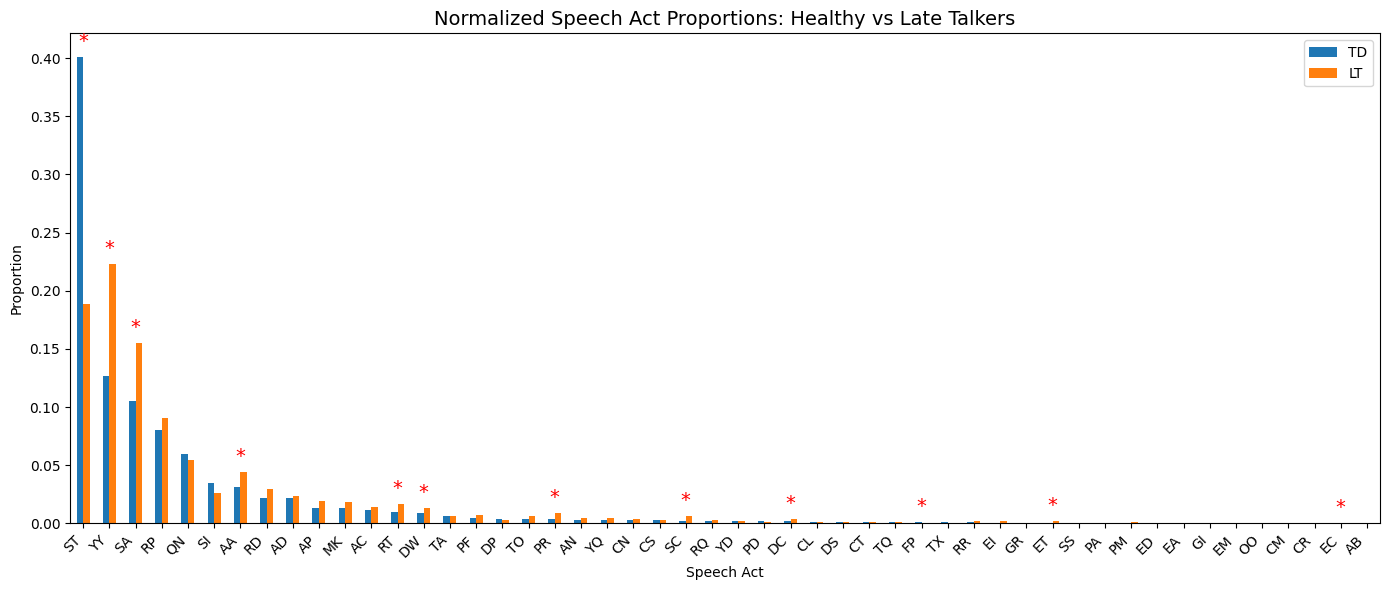

In [42]:
import matplotlib.pyplot as plt

# Calculate raw mean proportions for each speech act
mean_healthy = healthy_df.mean()
mean_lt = lt_df.mean()

# Combine into one DataFrame for plotting
speech_act_comparison = pd.DataFrame({
    'TD': mean_healthy,
    'LT': mean_lt
}).sort_values(by='TD', ascending=False).head(50)

# Normalize to proportions
speech_act_props = speech_act_comparison.div(speech_act_comparison.sum(axis=0), axis=1)

# Plot
ax = speech_act_props.plot(kind='bar', figsize=(14, 6), width=0.5)
plt.title("Normalized Speech Act Proportions: Healthy vs Late Talkers", fontsize=14)
plt.ylabel("Proportion")
plt.xlabel("Speech Act")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Add significance stars using t-test results
significant_acts = results_df[results_df['significant'] == True]['speech_act']
x_labels = speech_act_props.index

for i, label in enumerate(x_labels):
    if label in significant_acts.values:
        y_max = speech_act_props.loc[label].max()
        ax.text(i, y_max + 0.005, '*', ha='center', va='bottom', fontsize=14, color='red')

plt.show()


## Normalized frequency distribution of speech acts in the entire dataset

We replicate the results from Niklaus et.al(2022)

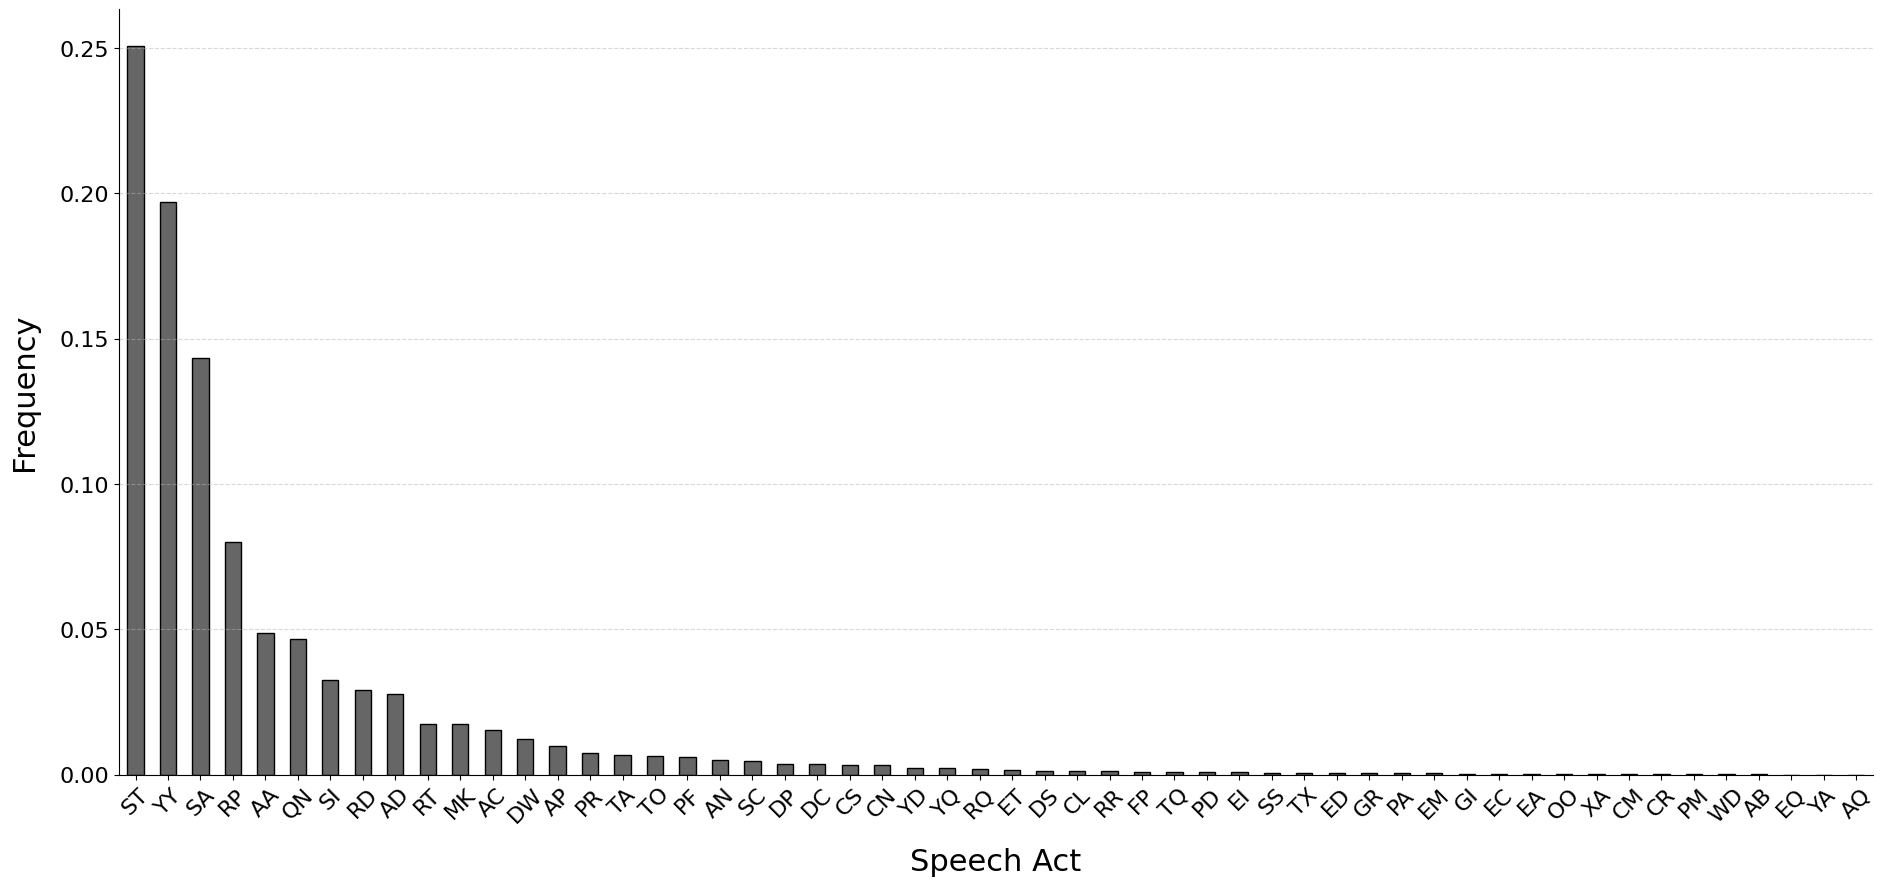

In [43]:
import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['DejaVu Sans']

plt.rcParams.update({
    "font.size": 16,
    "axes.titlesize": 20,
    "axes.labelsize": 18,
    "xtick.labelsize": 15,
    "ytick.labelsize": 15,
})

speech_act_distribution = data['speech_act'].value_counts(normalize=True).sort_values(ascending=False)

fig = plt.figure(figsize=(20, 10))
ax = speech_act_distribution.plot(
    kind='bar',
    color='0.4',        # Medium gray
    edgecolor='black'   # Black bar outlines
)

ax.set_xlabel("Speech Act", fontsize=22, labelpad=15)
ax.set_ylabel("Frequency", fontsize=22, labelpad=15)

ax.tick_params(axis='x', labelsize=16, rotation=45)
ax.tick_params(axis='y', labelsize=16)

for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

ax.grid(axis='y', linestyle='--', color='0.7', alpha=0.5)
ax.grid(axis='x', visible=False)

plt.tight_layout(pad=3.0)
plt.savefig("images/Figure 1 - Distribution of Freuqencies of Speech Acts Across the Selected Datasets.png", dpi=600, bbox_inches='tight')
plt.show()


## Graphing the speech act proportions across age buckets

This cell below configures calculates mean speech-act frequencies by age bucket and group (TD vs. LT), and plots four side-by-side bar charts showing their distributions. It adds counts, titles, grids, and axis labels, then saves the figure.

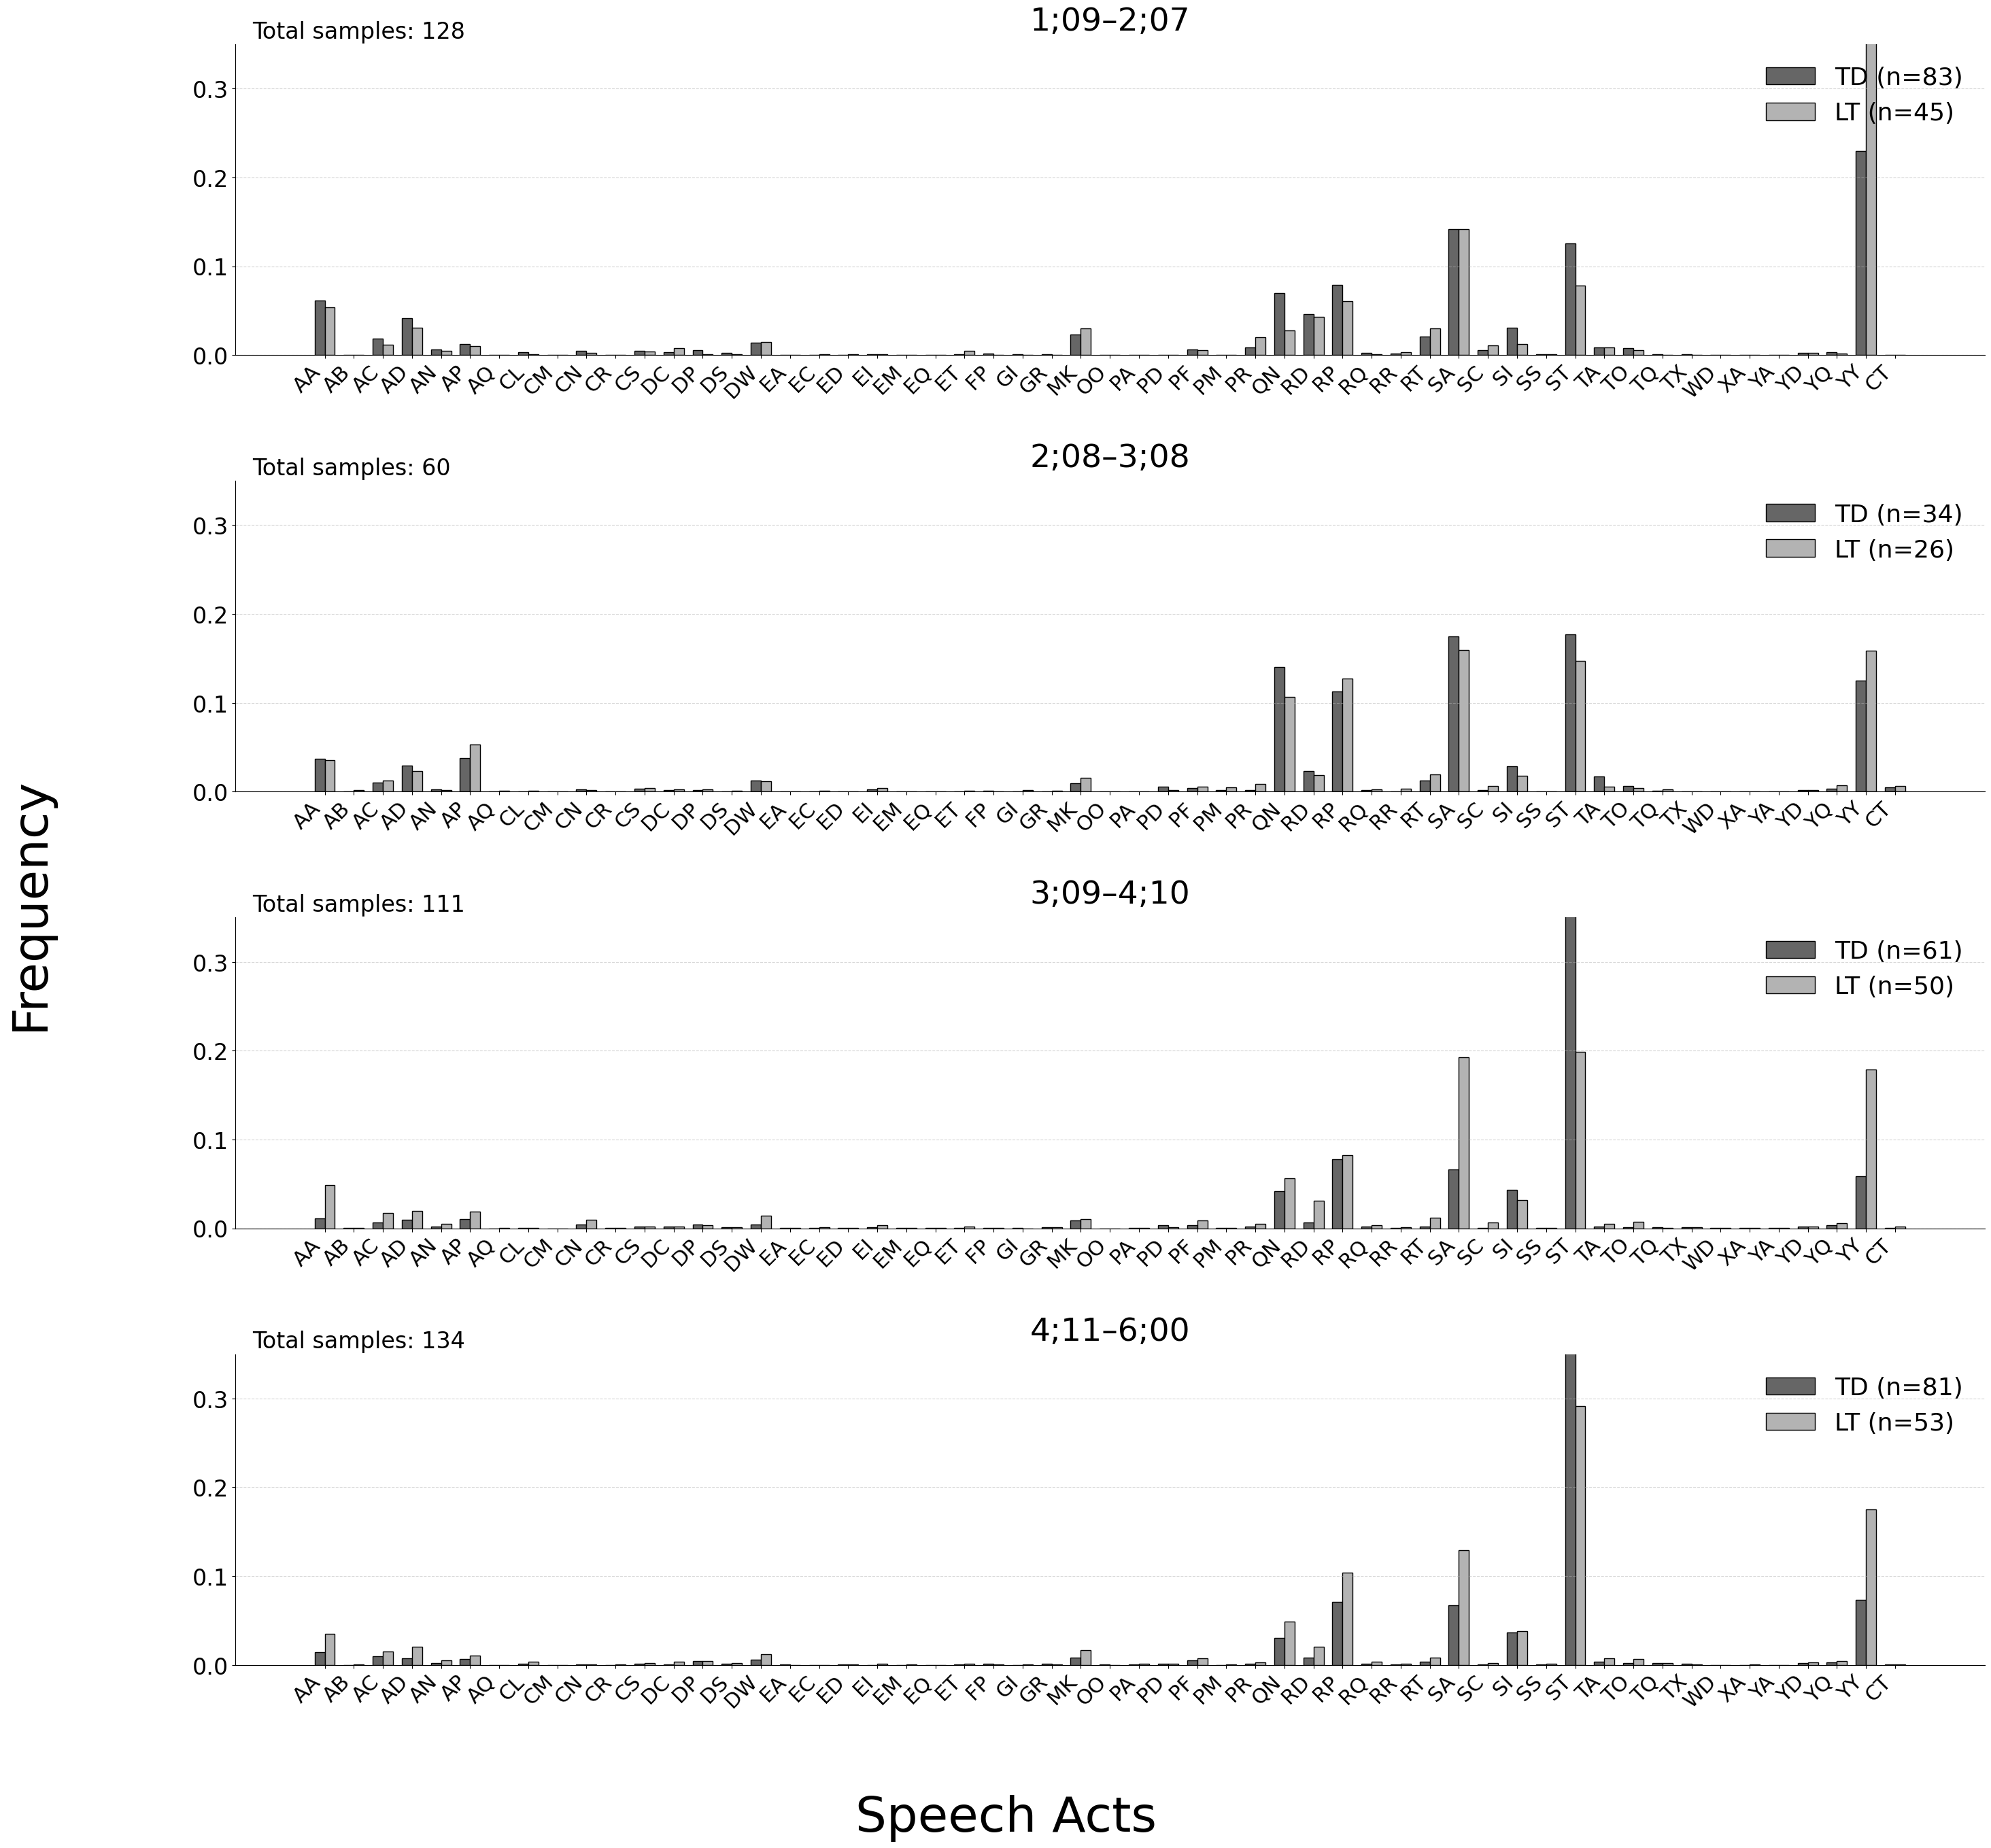

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

plt.rcdefaults()
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['DejaVu Sans']

# Font settings
plt.rcParams.update({
    "font.size": 22,
    "axes.titlesize": 34,
    "axes.labelsize": 30,
    "ytick.labelsize": 24,
    "legend.fontsize": 26
})

bucket_labels = ["1;09–2;07", "2;08–3;08", "3;09–4;10", "4;11–6;00"]
speech_act_columns = [col for col in speech_act_df.columns if col not in non_speech_act_columns]

global_max = 0
for bucket in range(4):
    bucket_df = speech_act_df[speech_act_df['assigned_bucket'] == bucket]
    means = bucket_df.groupby('label')[speech_act_columns].mean()
    if not means.empty:
        max_val = means.values.max()
        global_max = max(global_max, max_val)

ymax = 0.35
fig = plt.figure(figsize=(30, 30))

for bucket in range(4):
    bucket_df = speech_act_df[speech_act_df['assigned_bucket'] == bucket]
    td_count = len(bucket_df[bucket_df['label'] == 0])
    lt_count = len(bucket_df[bucket_df['label'] == 1])
    means = bucket_df.groupby('label')[speech_act_columns].mean()

    ax = plt.subplot(4, 1, bucket + 1)
    x = np.arange(len(speech_act_columns))
    width = 0.35

    td_vals = means.loc[0] if 0 in means.index else np.zeros(len(speech_act_columns))
    lt_vals = means.loc[1] if 1 in means.index else np.zeros(len(speech_act_columns))

    ax.bar(x - width/2, td_vals, width, color='0.4', edgecolor='black', label=f'TD (n={td_count})')
    ax.bar(x + width/2, lt_vals, width, color='0.7', edgecolor='black', label=f'LT (n={lt_count})')

    ax.set_title(f'{bucket_labels[bucket]}', pad=15)
    ax.set_xticks(x)
    ax.set_xticklabels(speech_act_columns, rotation=45, ha='right', fontsize=22)  # bigger speech-act labels
    ax.tick_params(axis='y', labelsize=24)
    ax.set_ylim(0, ymax)

    ax.legend(loc='upper right', frameon=False)

    ax.text(0.01, 1.02, f'Total samples: {td_count + lt_count}',
            transform=ax.transAxes, fontsize=24)

    ax.grid(axis='y', linestyle='--', color='0.7', alpha=0.5)
    ax.grid(axis='x', visible=False)

    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)

fig.supxlabel('Speech Acts', fontsize=52, y=0.04)
fig.supylabel('Frequency', fontsize=52, x=0.01)

plt.tight_layout(pad=2.0, rect=[0.03, 0.04, 1, 0.96])
#plt.savefig("images/Figure 3 - Frequency distribution of speech acts between TD and LT groups, and age groups.png", dpi=800, bbox_inches='tight')
plt.show()


Figure with significant differences marked

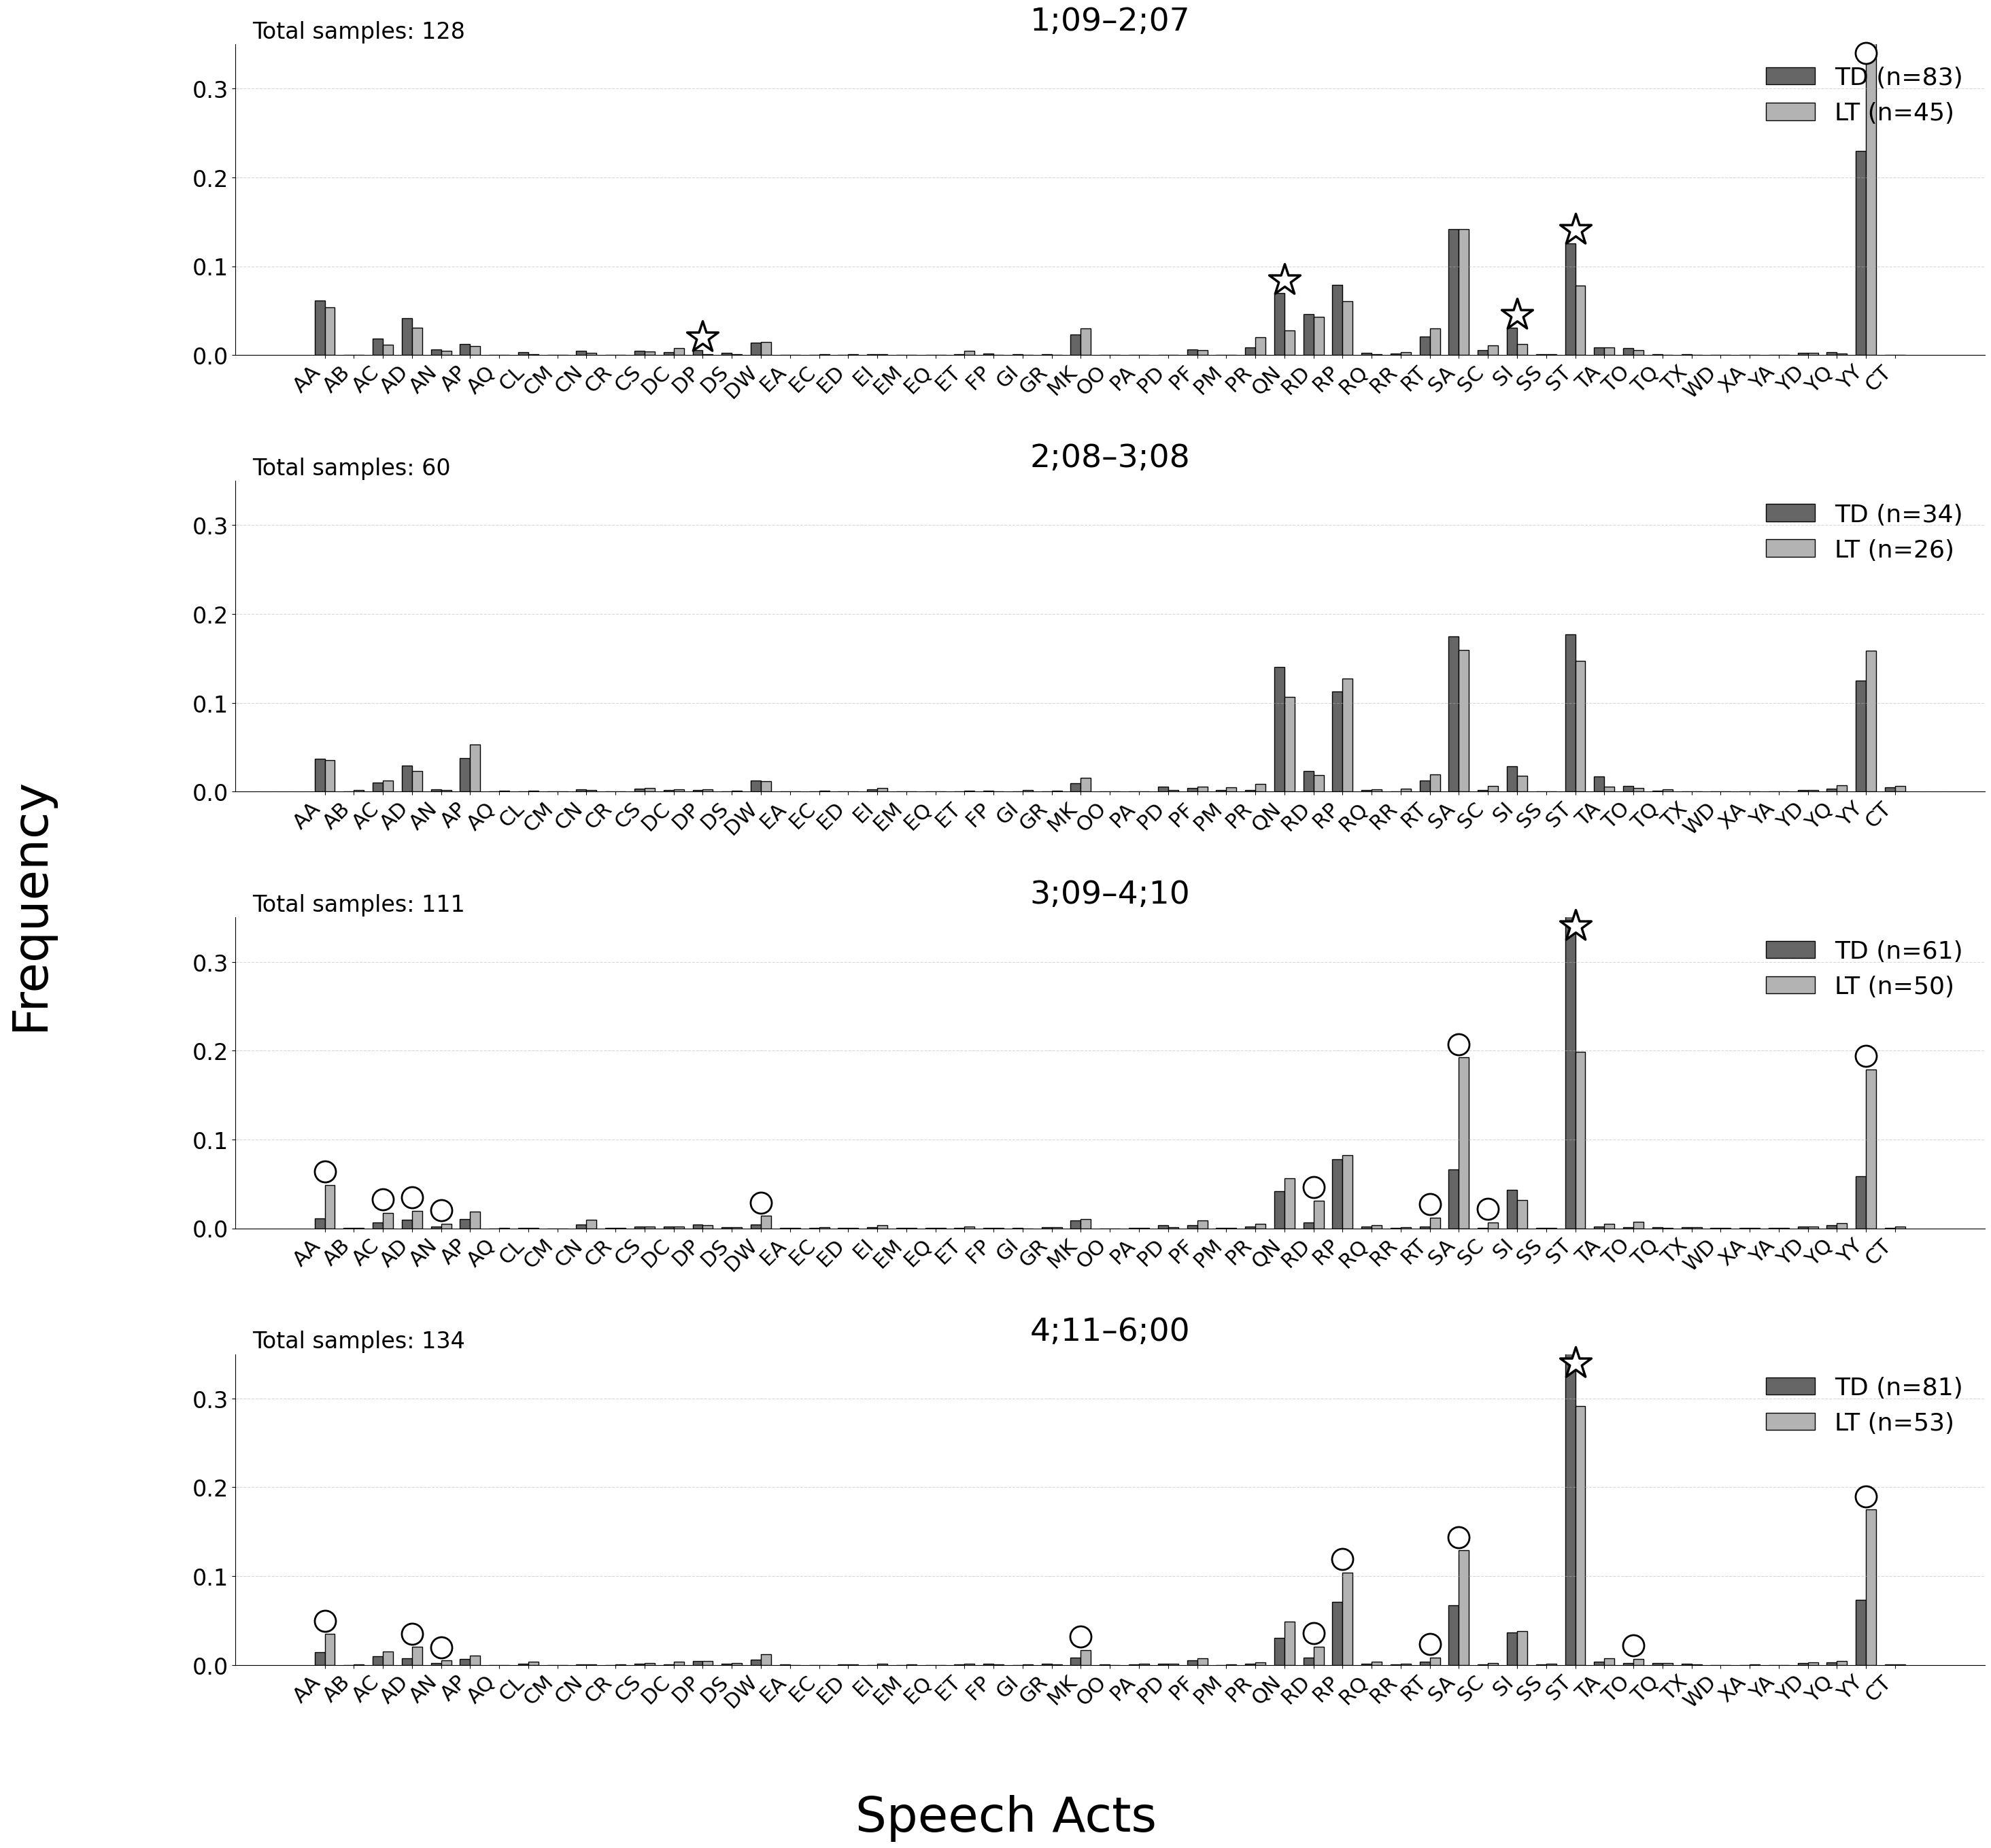

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests

plt.rcdefaults()
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['DejaVu Sans']

plt.rcParams.update({
    "font.size": 22,
    "axes.titlesize": 34,
    "axes.labelsize": 30,
    "ytick.labelsize": 24,
    "legend.fontsize": 26
})

# ---------- inputs ----------
bucket_labels = ["1;09–2;07", "2;08–3;08", "3;09–4;10", "4;11–6;00"]
speech_act_columns = [c for c in speech_act_df.columns if c not in non_speech_act_columns]

alpha = 0.05          # BH-FDR within bucket
marker_pad = 0.015    # vertical padding above tallest bar (in y-units)
ymax = 0.35

# ---------- helper: Welch t-tests + BH-FDR per bucket ----------
def sig_markers_for_bucket(bucket_df, cols, alpha=0.05):
    """
    Returns:
      sig_mask: boolean array len(cols) for FDR-significant features
      direction: array len(cols): +1 if TD>LT, -1 if LT>TD, 0 otherwise
      p_adj: adjusted p-values (nan where not tested)
    """
    if bucket_df['label'].nunique() < 2:
        return (np.zeros(len(cols), dtype=bool),
                np.zeros(len(cols), dtype=int),
                np.full(len(cols), np.nan))

    td_df = bucket_df.loc[bucket_df['label'] == 0, cols]
    lt_df = bucket_df.loc[bucket_df['label'] == 1, cols]

    raw_p = np.full(len(cols), np.nan)
    direction = np.zeros(len(cols), dtype=int)

    for j, col in enumerate(cols):
        td = pd.to_numeric(td_df[col], errors='coerce')
        lt = pd.to_numeric(lt_df[col], errors='coerce')

        if td.notna().sum() >= 2 and lt.notna().sum() >= 2:
            t_stat, p_val = ttest_ind(td, lt, equal_var=False, nan_policy='omit')
            raw_p[j] = p_val

            td_mean = np.nanmean(td.values)
            lt_mean = np.nanmean(lt.values)
            if td_mean > lt_mean:
                direction[j] = +1   # TD > LT
            elif lt_mean > td_mean:
                direction[j] = -1   # LT > TD
            else:
                direction[j] = 0

    valid = ~np.isnan(raw_p)
    p_adj = np.full(len(cols), np.nan)
    sig = np.zeros(len(cols), dtype=bool)

    if valid.any():
        rej, adj, _, _ = multipletests(raw_p[valid], alpha=alpha, method='fdr_bh')
        sig[valid] = rej
        p_adj[valid] = adj

    return sig, direction, p_adj


# ---------- plot ----------
fig = plt.figure(figsize=(30, 30))

for bucket in range(4):
    bucket_df = speech_act_df[speech_act_df['assigned_bucket'] == bucket]

    td_count = int((bucket_df['label'] == 0).sum())
    lt_count = int((bucket_df['label'] == 1).sum())

    means = bucket_df.groupby('label')[speech_act_columns].mean()

    ax = plt.subplot(4, 1, bucket + 1)
    x = np.arange(len(speech_act_columns))
    width = 0.35

    td_vals = means.loc[0].values if 0 in means.index else np.zeros(len(speech_act_columns))
    lt_vals = means.loc[1].values if 1 in means.index else np.zeros(len(speech_act_columns))

    ax.bar(x - width/2, td_vals, width, color='0.4', edgecolor='black', label=f'TD (n={td_count})')
    ax.bar(x + width/2, lt_vals, width, color='0.7', edgecolor='black', label=f'LT (n={lt_count})')

    ax.set_title(f'{bucket_labels[bucket]}', pad=15)
    ax.set_xticks(x)
    ax.set_xticklabels(speech_act_columns, rotation=45, ha='right', fontsize=22)
    ax.tick_params(axis='y', labelsize=24)
    ax.set_ylim(0, ymax)
    ax.legend(loc='upper right', frameon=False)

    ax.text(0.01, 1.02, f'Total samples: {td_count + lt_count}',
            transform=ax.transAxes, fontsize=24)

    ax.grid(axis='y', linestyle='--', color='0.7', alpha=0.5)
    ax.grid(axis='x', visible=False)
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)

    # ---------- add significance markers ----------
    sig_mask, direction, p_adj = sig_markers_for_bucket(bucket_df, speech_act_columns, alpha=alpha)

    # marker y-position: slightly above the tallest bar at that x
    local_tops = np.maximum(td_vals, lt_vals)
    y_mark = np.minimum(local_tops + marker_pad, ymax - 0.01)

    # TD > LT: star
    idx_star = np.where(sig_mask & (direction == +1))[0]
    if idx_star.size:
        ax.scatter(
            x[idx_star],
            y_mark[idx_star],
            marker='*',
            s=1200,
            facecolors='white',     # white fill
            edgecolors='black',     # black outline
            linewidths=2.5,
            zorder=10,
            clip_on=False
        )

    # LT > TD: circle
    idx_circle = np.where(sig_mask & (direction == -1))[0]
    if idx_circle.size:
        ax.scatter(x[idx_circle], y_mark[idx_circle],
                   marker='o', s=500, facecolors='white', edgecolors='black', linewidths=2,
                   zorder=10, clip_on=False)


fig.supxlabel('Speech Acts', fontsize=52, y=0.04)
fig.supylabel('Frequency', fontsize=52, x=0.01)

plt.tight_layout(pad=2.0, rect=[0.03, 0.04, 1, 0.96])
plt.savefig(
    "images/Figure 3 - Frequency distribution of speech acts between TD and LT groups, and age groups (significance marked).png",
    dpi=800, bbox_inches='tight'
)
plt.show()


# Classification using Only Speech Acts

In [46]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, make_scorer
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import pandas as pd
from sklearn.preprocessing import normalize
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline



In [47]:
X = speech_act_df.drop(columns=non_speech_act_columns)
y = speech_act_df['label']
X = pd.DataFrame(normalize(X), columns=X.columns)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Define classifiers
models = {
    'Decision Tree': DecisionTreeClassifier(),
    'SVM': SVC(),
    'KNN': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier()
}
models["SVM"] = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", SVC())
])

## Cross Validation

4-fold CV

In [48]:
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

# Define custom scorers to avoid warnings
f1 = make_scorer(f1_score, zero_division=0)
precision = make_scorer(precision_score, zero_division=0)
recall = make_scorer(recall_score, zero_division=0)

# Prepare list for storing results
cv_results = []

# Loop through models
for name, model in models.items():
    acc = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
    f1_scores = cross_val_score(model, X, y, cv=cv, scoring=f1)
    prec_scores = cross_val_score(model, X, y, cv=cv, scoring=precision)
    rec_scores = cross_val_score(model, X, y, cv=cv, scoring=recall)

    cv_results.append({
        'Model': name,
        'Accuracy': round(acc.mean(), 3),
        'F1 Score': round(f1_scores.mean(), 3),
        'Precision': round(prec_scores.mean(), 3),
        'Recall': round(rec_scores.mean(), 3),
    })

# Create DataFrame
cv_df = pd.DataFrame(cv_results)
cv_df_sorted = cv_df.sort_values(by='F1 Score', ascending=False).reset_index(drop=True)

cv_df_sorted.to_excel("tables/cv_results.xlsx", index=False)

print(cv_df_sorted)


           Model  Accuracy  F1 Score  Precision  Recall
0  Random Forest     0.721     0.624      0.687   0.586
1            KNN     0.695     0.600      0.638   0.575
2            SVM     0.700     0.578      0.664   0.541
3        XGBoost     0.677     0.573      0.613   0.541
4  Decision Tree     0.617     0.510      0.503   0.511
5    Naive Bayes     0.642     0.466      0.562   0.412


5-fold CV

In [49]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define custom scorers to avoid warnings
f1 = make_scorer(f1_score, zero_division=0)
precision = make_scorer(precision_score, zero_division=0)
recall = make_scorer(recall_score, zero_division=0)

# Prepare list for storing results
cv_results = []

# Loop through models
for name, model in models.items():
    acc = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
    f1_scores = cross_val_score(model, X, y, cv=cv, scoring=f1)
    prec_scores = cross_val_score(model, X, y, cv=cv, scoring=precision)
    rec_scores = cross_val_score(model, X, y, cv=cv, scoring=recall)

    cv_results.append({
        'Model': name,
        'Accuracy': round(acc.mean(), 3),
        'F1 Score': round(f1_scores.mean(), 3),
        'Precision': round(prec_scores.mean(), 3),
        'Recall': round(rec_scores.mean(), 3),
        'Accuracy Std': round(acc.std(), 3)
    })

# Create DataFrame
cv_df = pd.DataFrame(cv_results)
cv_df_sorted = cv_df.sort_values(by='F1 Score', ascending=False).reset_index(drop=True)

cv_df_sorted.to_excel("tables/5_cv_results.xlsx", index=False)

print(cv_df_sorted)


           Model  Accuracy  F1 Score  Precision  Recall  Accuracy Std
0  Random Forest     0.691     0.580      0.640   0.540         0.018
1        XGBoost     0.672     0.577      0.605   0.564         0.026
2            KNN     0.677     0.574      0.612   0.546         0.026
3            SVM     0.686     0.570      0.634   0.529         0.024
4  Decision Tree     0.619     0.524      0.521   0.494         0.044
5    Naive Bayes     0.628     0.460      0.557   0.402         0.041


## Area under the curve for best performing model

We computed the ROC (Receiver Operating Characteristic) curve and AUC (Area under the Curve) for the Random Forest classifier using out-of-fold predictions from four-fold stratified cross-validation. The ROC curve shows the trade-off between true positive rate and false positive rate across thresholds. The AUC value summarizes overall discrimination performance, where 0.5 indicates chance-level classification and 1.0 indicates perfect separation. The obtained AUC indicates that the model can reliably distinguish late-talking and typically developing children based on speech act features.

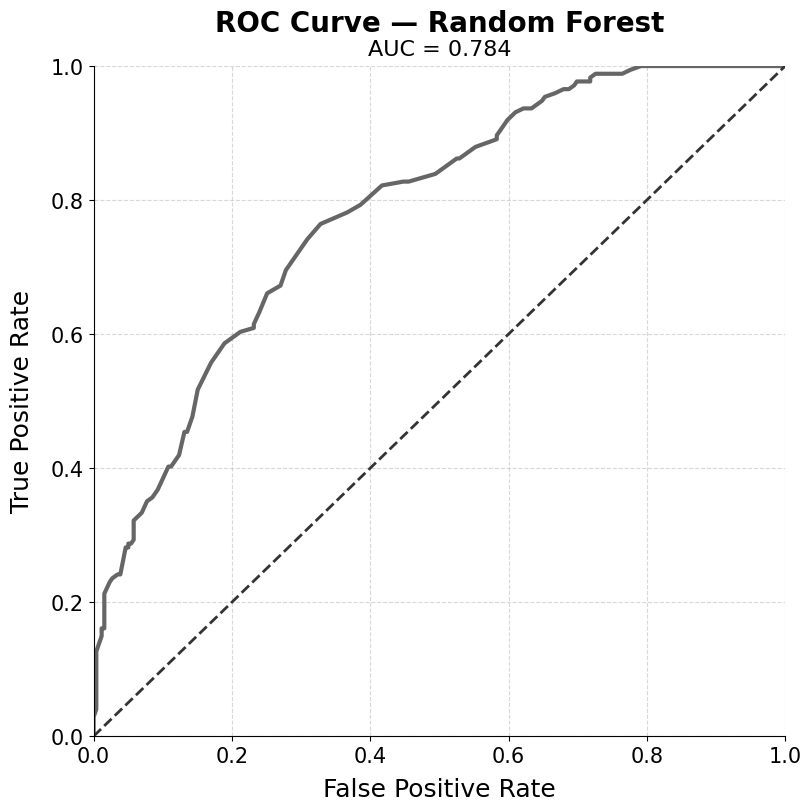

In [50]:
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from matplotlib import font_manager, rcParams

# Separate features and labels
X = speech_act_df.drop(columns=non_speech_act_columns)
y = speech_act_df['label']

# Normalize speech act features
X = pd.DataFrame(normalize(X), columns=X.columns)

# Set font and figure style to match other plots
available_fonts = [f.name for f in font_manager.fontManager.ttflist]
rcParams["font.family"] = "Calibri" if "Calibri" in available_fonts else "sans-serif"

plt.rcParams.update({
    "font.size": 16,
    "axes.titlesize": 20,
    "axes.labelsize": 18,
    "xtick.labelsize": 15,
    "ytick.labelsize": 15,
})

# Stratified CV to preserve LT/TD class balance
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

# Use best performing model
rf = models["Random Forest"]

# Get out-of-fold probability predictions
y_prob = cross_val_predict(rf, X, y, cv=cv, method="predict_proba")[:, 1]

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y, y_prob)
roc_auc = auc(fpr, tpr)

# Create ROC plot
fig, ax = plt.subplots(figsize=(8, 8), constrained_layout=True)

ax.plot(fpr, tpr, color="0.4", linewidth=3)
ax.plot([0, 1], [0, 1], linestyle="--", color="0.2", linewidth=2)

# Main title with extra padding
ax.set_title("ROC Curve — Random Forest", pad=25, weight="bold")

# Subtitle placed just below the title
ax.text(
    0.5, 1.01,
    f"AUC = {roc_auc:.3f}",
    transform=ax.transAxes,
    ha="center",
    va="bottom",
    fontsize=16
)
ax.set_xlabel("False Positive Rate", labelpad=8)
ax.set_ylabel("True Positive Rate", labelpad=12)

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

# Light gridlines
ax.grid(axis="both", linestyle="--", color="0.7", alpha=0.5)

# Clean frame
for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)

plt.savefig("images/ROC - Random Forest.png", dpi=600, bbox_inches="tight")
plt.show()


## Hyperparameter Tuning for Random Forest Model

In [51]:
import numpy as np

rf = models['Random Forest']

# Parameter grid
param_dist = {
    'n_estimators': [int(x) for x in np.linspace(100, 1000, 10)],
    'max_depth': [None] + list(np.arange(5, 31, 5)),
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True]
}

# Cross-validation setup
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

# Define multiple metrics
scoring = {
    'accuracy': 'accuracy',
    'f1': 'f1',
    'precision': 'precision',
    'recall': 'recall'
}

# RandomizedSearchCV with multiple scoring
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=150,
    scoring=scoring,
    refit='accuracy',  # Refits based on best accuracy
    cv=cv,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit on training data
random_search.fit(X, y)
best_rf = random_search.best_estimator_
models['Random Forest'] = best_rf

# Output best parameters and CV metrics
print("Best Random Forest Parameters:")
print(random_search.best_params_)

mean_test_acc = random_search.cv_results_['mean_test_accuracy'][random_search.best_index_]
mean_test_f1 = random_search.cv_results_['mean_test_f1'][random_search.best_index_]
mean_test_prec = random_search.cv_results_['mean_test_precision'][random_search.best_index_]
mean_test_rec = random_search.cv_results_['mean_test_recall'][random_search.best_index_]

print(f"Best CV Accuracy:  {mean_test_acc:.4f}")
print(f"Best CV F1 Score:  {mean_test_f1:.4f}")
print(f"Best CV Precision: {mean_test_prec:.4f}")
print(f"Best CV Recall:    {mean_test_rec:.4f}")


Fitting 4 folds for each of 150 candidates, totalling 600 fits
Best Random Forest Parameters:
{'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': np.int64(20), 'bootstrap': True}
Best CV Accuracy:  0.7299
Best CV F1 Score:  0.6383
Best CV Precision: 0.7024
Best CV Recall:    0.5921


### Random Forest Feature Importance

In [52]:


# Get feature importances
importances = best_rf.feature_importances_

# If X is a DataFrame, use column names
if hasattr(X, "columns"):
    feature_names = X.columns
else:
    feature_names = [f"Feature_{i}" for i in range(len(importances))]

# Create importance table
rf_feature_importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
})

# Sort descending
rf_feature_importance_df = rf_feature_importance_df.sort_values(
    by="Importance",
    ascending=False
).reset_index(drop=True)

# Optional: normalize to percentages
rf_feature_importance_df["Importance (%)"] = (
    rf_feature_importance_df["Importance"] /
    rf_feature_importance_df["Importance"].sum()
) * 100

# Display table
print(rf_feature_importance_df)
rf_feature_importance_df.to_csv("tables/random_forest_importance.csv", index=False)


   Feature  Importance  Importance (%)
0       ST    0.076521        7.652128
1       YY    0.076054        7.605402
2       SA    0.053301        5.330086
3       AD    0.046729        4.672915
4       RP    0.046263        4.626309
5       SI    0.039685        3.968461
6       QN    0.038763        3.876323
7       AA    0.036689        3.668926
8       RT    0.034651        3.465127
9       RD    0.033304        3.330410
10      MK    0.030800        3.079958
11      DW    0.030607        3.060671
12      AP    0.029770        2.976958
13      AC    0.029691        2.969102
14      PF    0.025608        2.560797
15      SC    0.023678        2.367817
16      TA    0.022818        2.281847
17      PR    0.021421        2.142136
18      DP    0.019772        1.977156
19      AN    0.019507        1.950724
20      RQ    0.019295        1.929485
21      TO    0.018383        1.838323
22      YQ    0.018217        1.821691
23      ET    0.014736        1.473628
24      CS    0.014261   

## Dendrogram: Feature Clustering Based on Correlation

This dendrogram shows hierarchical clustering of features based on their pairwise **absolute Pearson correlation**. Correlations were converted to distances using `1 - |correlation|`, so strongly related features (positively or negatively) are clustered together. The **Ward linkage method** was used to minimize variance within clusters. Features that join lower in the tree are more similar in behavior across samples.


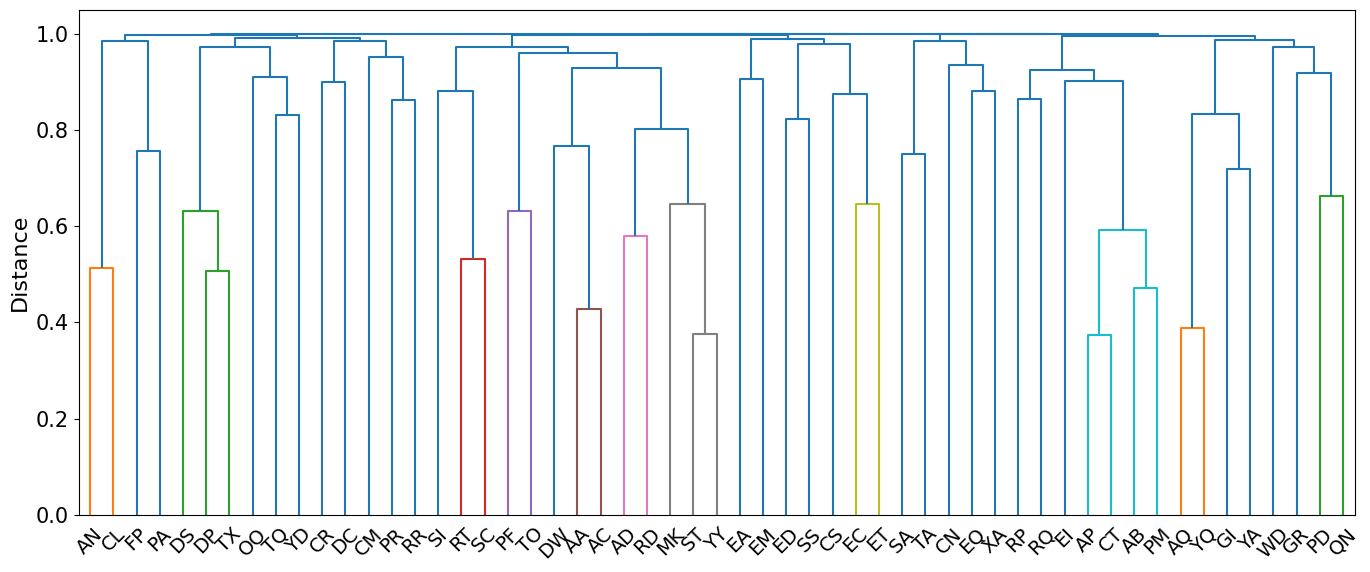

In [53]:
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import squareform

X = speech_act_df.drop(columns=non_speech_act_columns)

# Compute absolute correlation matrix of features
corr = X.corr().abs()
# Convert correlation to distance matrix (1 - correlation), transforms similarity into distance
distance_matrix = 1 - corr

# Convert to condensed distance matrix for linkage
condensed_dist = squareform(distance_matrix)

# Hierarchical clustering
linkage_matrix = linkage(condensed_dist, method='complete')

# Plot dendrogram
plt.figure(figsize=(14, 6))
dendrogram(linkage_matrix, labels=X.columns, leaf_rotation=45, leaf_font_size=14)
plt.ylabel("Distance", fontsize=16)
plt.tight_layout()
plt.savefig("images/Dendogram.png", dpi=300)
plt.show()


## Hierarchical Clustering

In [54]:
from scipy.cluster.hierarchy import fcluster
import pandas as pd

# exactly 7 clusters to mirror manual top-level families
clusters = fcluster(linkage_matrix, t=7, criterion='maxclust')

# Map each feature to its cluster (keep deterministic order within cluster)
feature_clusters = (
    pd.DataFrame({'feature': corr.columns, 'cluster': clusters})
    .sort_values(['cluster', 'feature'])
)

# Build the "one row per cluster" table
cluster_df = (
    feature_clusters
    .groupby('cluster', as_index=False)['feature']
    .apply(lambda s: ', '.join(s.tolist()))
    .rename(columns={'feature': 'members'})
    .sort_values('cluster')
    .reset_index(drop=True)
)

print(cluster_df)
cluster_df.to_csv("images/speech_act_clusters.csv", index=False)


   cluster                                            members
0        1                                     AN, CL, FP, PA
1        2         CM, CR, DC, DP, DS, OO, PR, RR, TQ, TX, YD
2        3  AA, AC, AD, DW, MK, PF, RD, RT, SC, SI, ST, TO...
3        4                         CS, EA, EC, ED, EM, ET, SS
4        5                                 CN, EQ, SA, TA, XA
5        6                         AB, AP, CT, EI, PM, RP, RQ
6        7                     AQ, GI, GR, PD, QN, WD, YA, YQ


In [55]:
X_clustered = pd.DataFrame(index=X.index)

# Group features by their assigned cluster and average them row-wise
for cluster_id, features in feature_clusters.groupby('cluster')['feature']:
    # Only keep features present in X
    valid_features = [f for f in features if f in X.columns]

    # Compute the row-wise average for this cluster and assign a new feature name
    X_clustered[f'cluster_{cluster_id}'] = X[valid_features].mean(axis=1)

# Final DataFrame with merged cluster features
X_clustered


,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7
0,0.003086,0.005612,0.045584,0.000000,0.054321,0.003527,0.003086
1,0.000000,0.001038,0.037055,0.002194,0.033797,0.013786,0.028254
2,0.000000,0.006285,0.035945,0.000794,0.046420,0.010758,0.018827
3,0.001954,0.002149,0.043852,0.001143,0.021997,0.012310,0.024290
4,0.003086,0.001684,0.055556,0.000000,0.040741,0.002646,0.002315
...,...,...,...,...,...,...,...
428,0.005882,0.003209,0.051584,0.001681,0.030588,0.010084,0.004412
429,0.000000,0.001337,0.028281,0.000000,0.082353,0.010504,0.016544
430,0.000000,0.001684,0.024217,0.000000,0.111111,0.005291,0.006944
431,0.000000,0.000000,0.030220,0.001701,0.090476,0.015306,0.000000


### Dendrogram

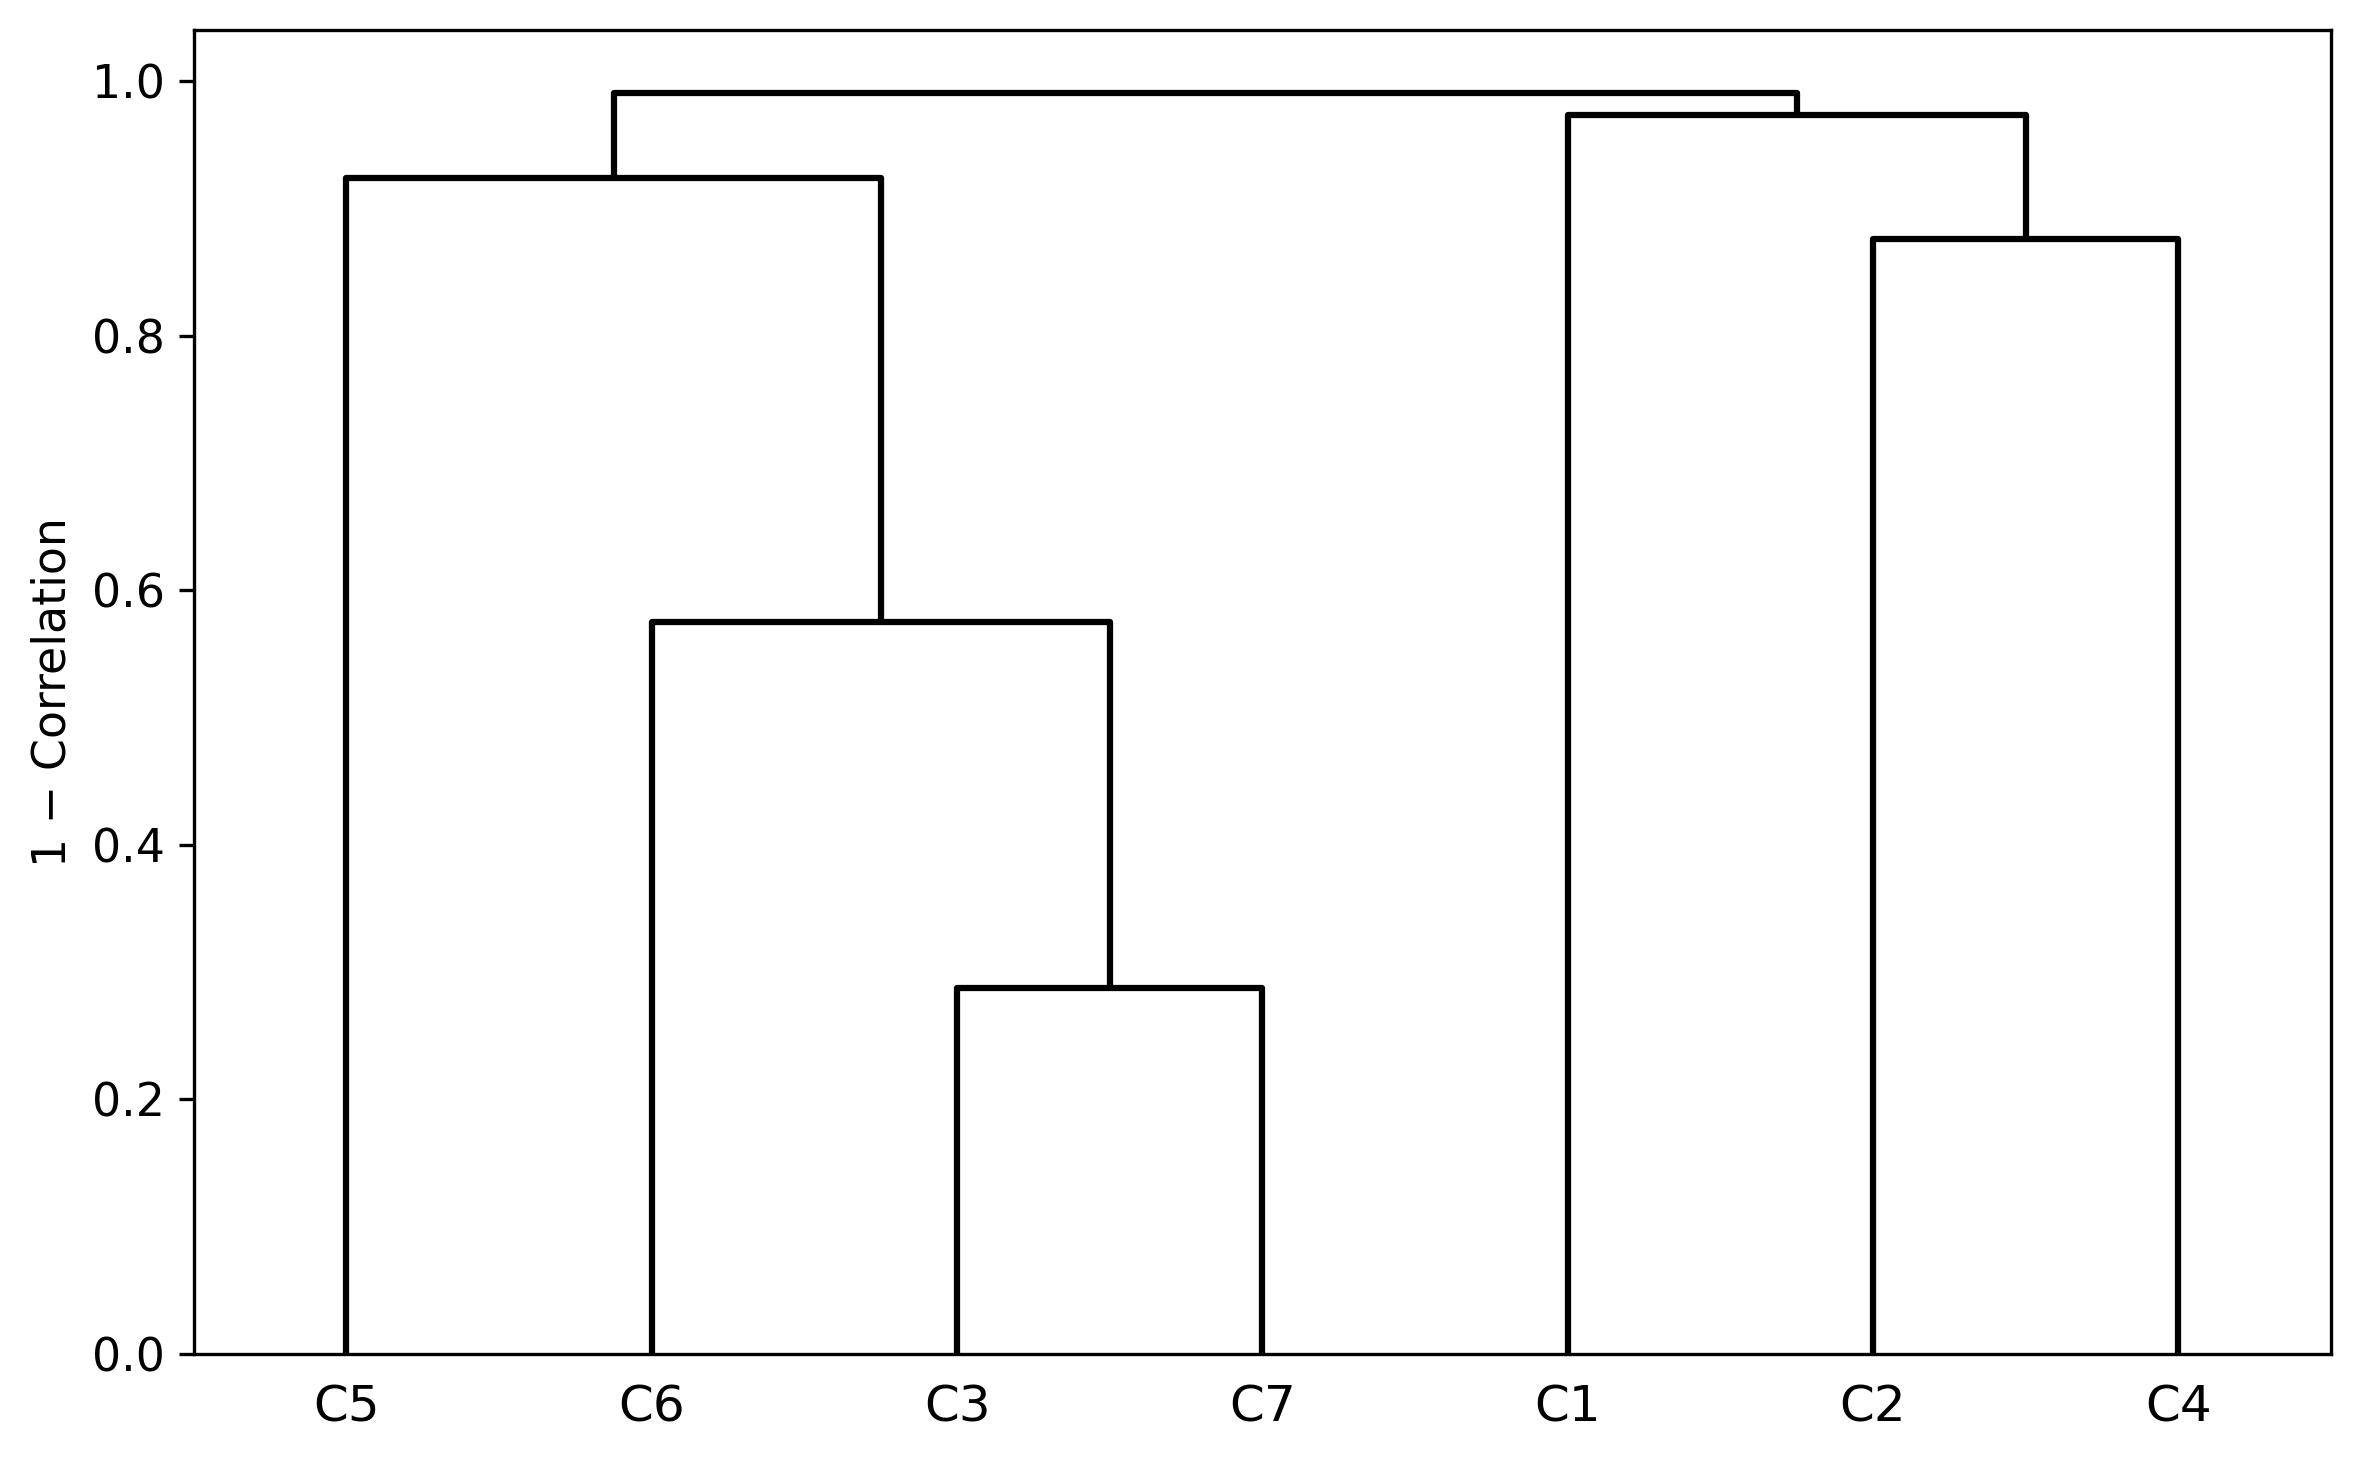

In [56]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import squareform

mpl.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["Calibri", "DejaVu Sans"],
    "font.size": 11,
    "axes.titlesize": 11,
    "axes.labelsize": 11,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "legend.fontsize": 11,
    "figure.dpi": 300
})
mpl.rcParams["pdf.fonttype"] = 42
mpl.rcParams["ps.fonttype"] = 42

# Use non-constant cluster features
cols = [c for c in X_clustered.columns if X_clustered[c].std(skipna=True) > 0]
Xc = X_clustered[cols].copy()

# Correlation
R = Xc.corr().abs()
np.fill_diagonal(R.values, 1.0)
D = 1.0 - R

# Linkage
Z = linkage(squareform(D.values, checks=False), method='complete')

cluster_ids_in_order = []
for i, c in enumerate(Xc.columns):
    try:
        cluster_ids_in_order.append(int(str(c).split('_')[-1]))  # expects 'cluster_#'
    except Exception:
        cluster_ids_in_order.append(i + 1)  # fallback

labels = [f"C{cid}" for cid in cluster_ids_in_order]

# Plot
plt.figure(figsize=(8, 5))
dendrogram(
    Z,
    labels=labels,
    leaf_rotation=0,
    color_threshold=0,     # ensure all lines are same color
    above_threshold_color="black",
)

plt.ylabel('1 − Correlation')
plt.tight_layout()
plt.savefig("images/Figure 4 - Dendrogram of hierarchically clustered features.png", dpi=300)
plt.show()


### Classification using clustered groups of speech acts

In [57]:
X_clustered = pd.DataFrame(normalize(X_clustered), columns=X_clustered.columns)
y = speech_act_df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X_clustered, y, test_size=0.2, stratify=y, random_state=42
)

models = {
    'Logistic Regression': LogisticRegression(),
    'SVM': SVC(),
    'KNN': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier()
}

In [58]:
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

# defining custom scorers avoids warnings
f1 = make_scorer(f1_score, zero_division=0)
precision = make_scorer(precision_score, zero_division=0)
recall = make_scorer(recall_score, zero_division=0)

cv_results = []

for name, model in models.items():
    acc = cross_val_score(model, X_clustered, y, cv=cv, scoring='accuracy')
    f1_scores = cross_val_score(model, X_clustered, y, cv=cv, scoring=f1)
    prec_scores = cross_val_score(model, X_clustered, y, cv=cv, scoring=precision)
    rec_scores = cross_val_score(model, X_clustered, y, cv=cv, scoring=recall)

    cv_results.append({
        'Model': name,
        'Accuracy': round(acc.mean(), 3),
        'F1 Score': round(f1_scores.mean(), 3),
        'Precision': round(prec_scores.mean(), 3),
        'Recall': round(rec_scores.mean(), 3),
        'Accuracy Std': round(acc.std(), 3)
    })

cv_df = pd.DataFrame(cv_results)
cv_df_sorted = cv_df.sort_values(by='Accuracy', ascending=False).reset_index(drop=True)
cv_df_sorted.to_excel('hierarchical_clustering_cv.xlsx', index=False)
print(cv_df_sorted)


                 Model  Accuracy  F1 Score  Precision  Recall  Accuracy Std
0                  SVM     0.640     0.400      0.630   0.299         0.048
1              XGBoost     0.628     0.517      0.539   0.500         0.035
2        Random Forest     0.624     0.472      0.542   0.420         0.012
3  Logistic Regression     0.621     0.363      0.616   0.265         0.061
4          Naive Bayes     0.619     0.493      0.528   0.466         0.057
5                  KNN     0.594     0.444      0.485   0.414         0.035


# Analysing distribution of distinct speech act production across age groups

In [59]:
from pathlib import Path
from typing import Dict, Tuple
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import numpy as np



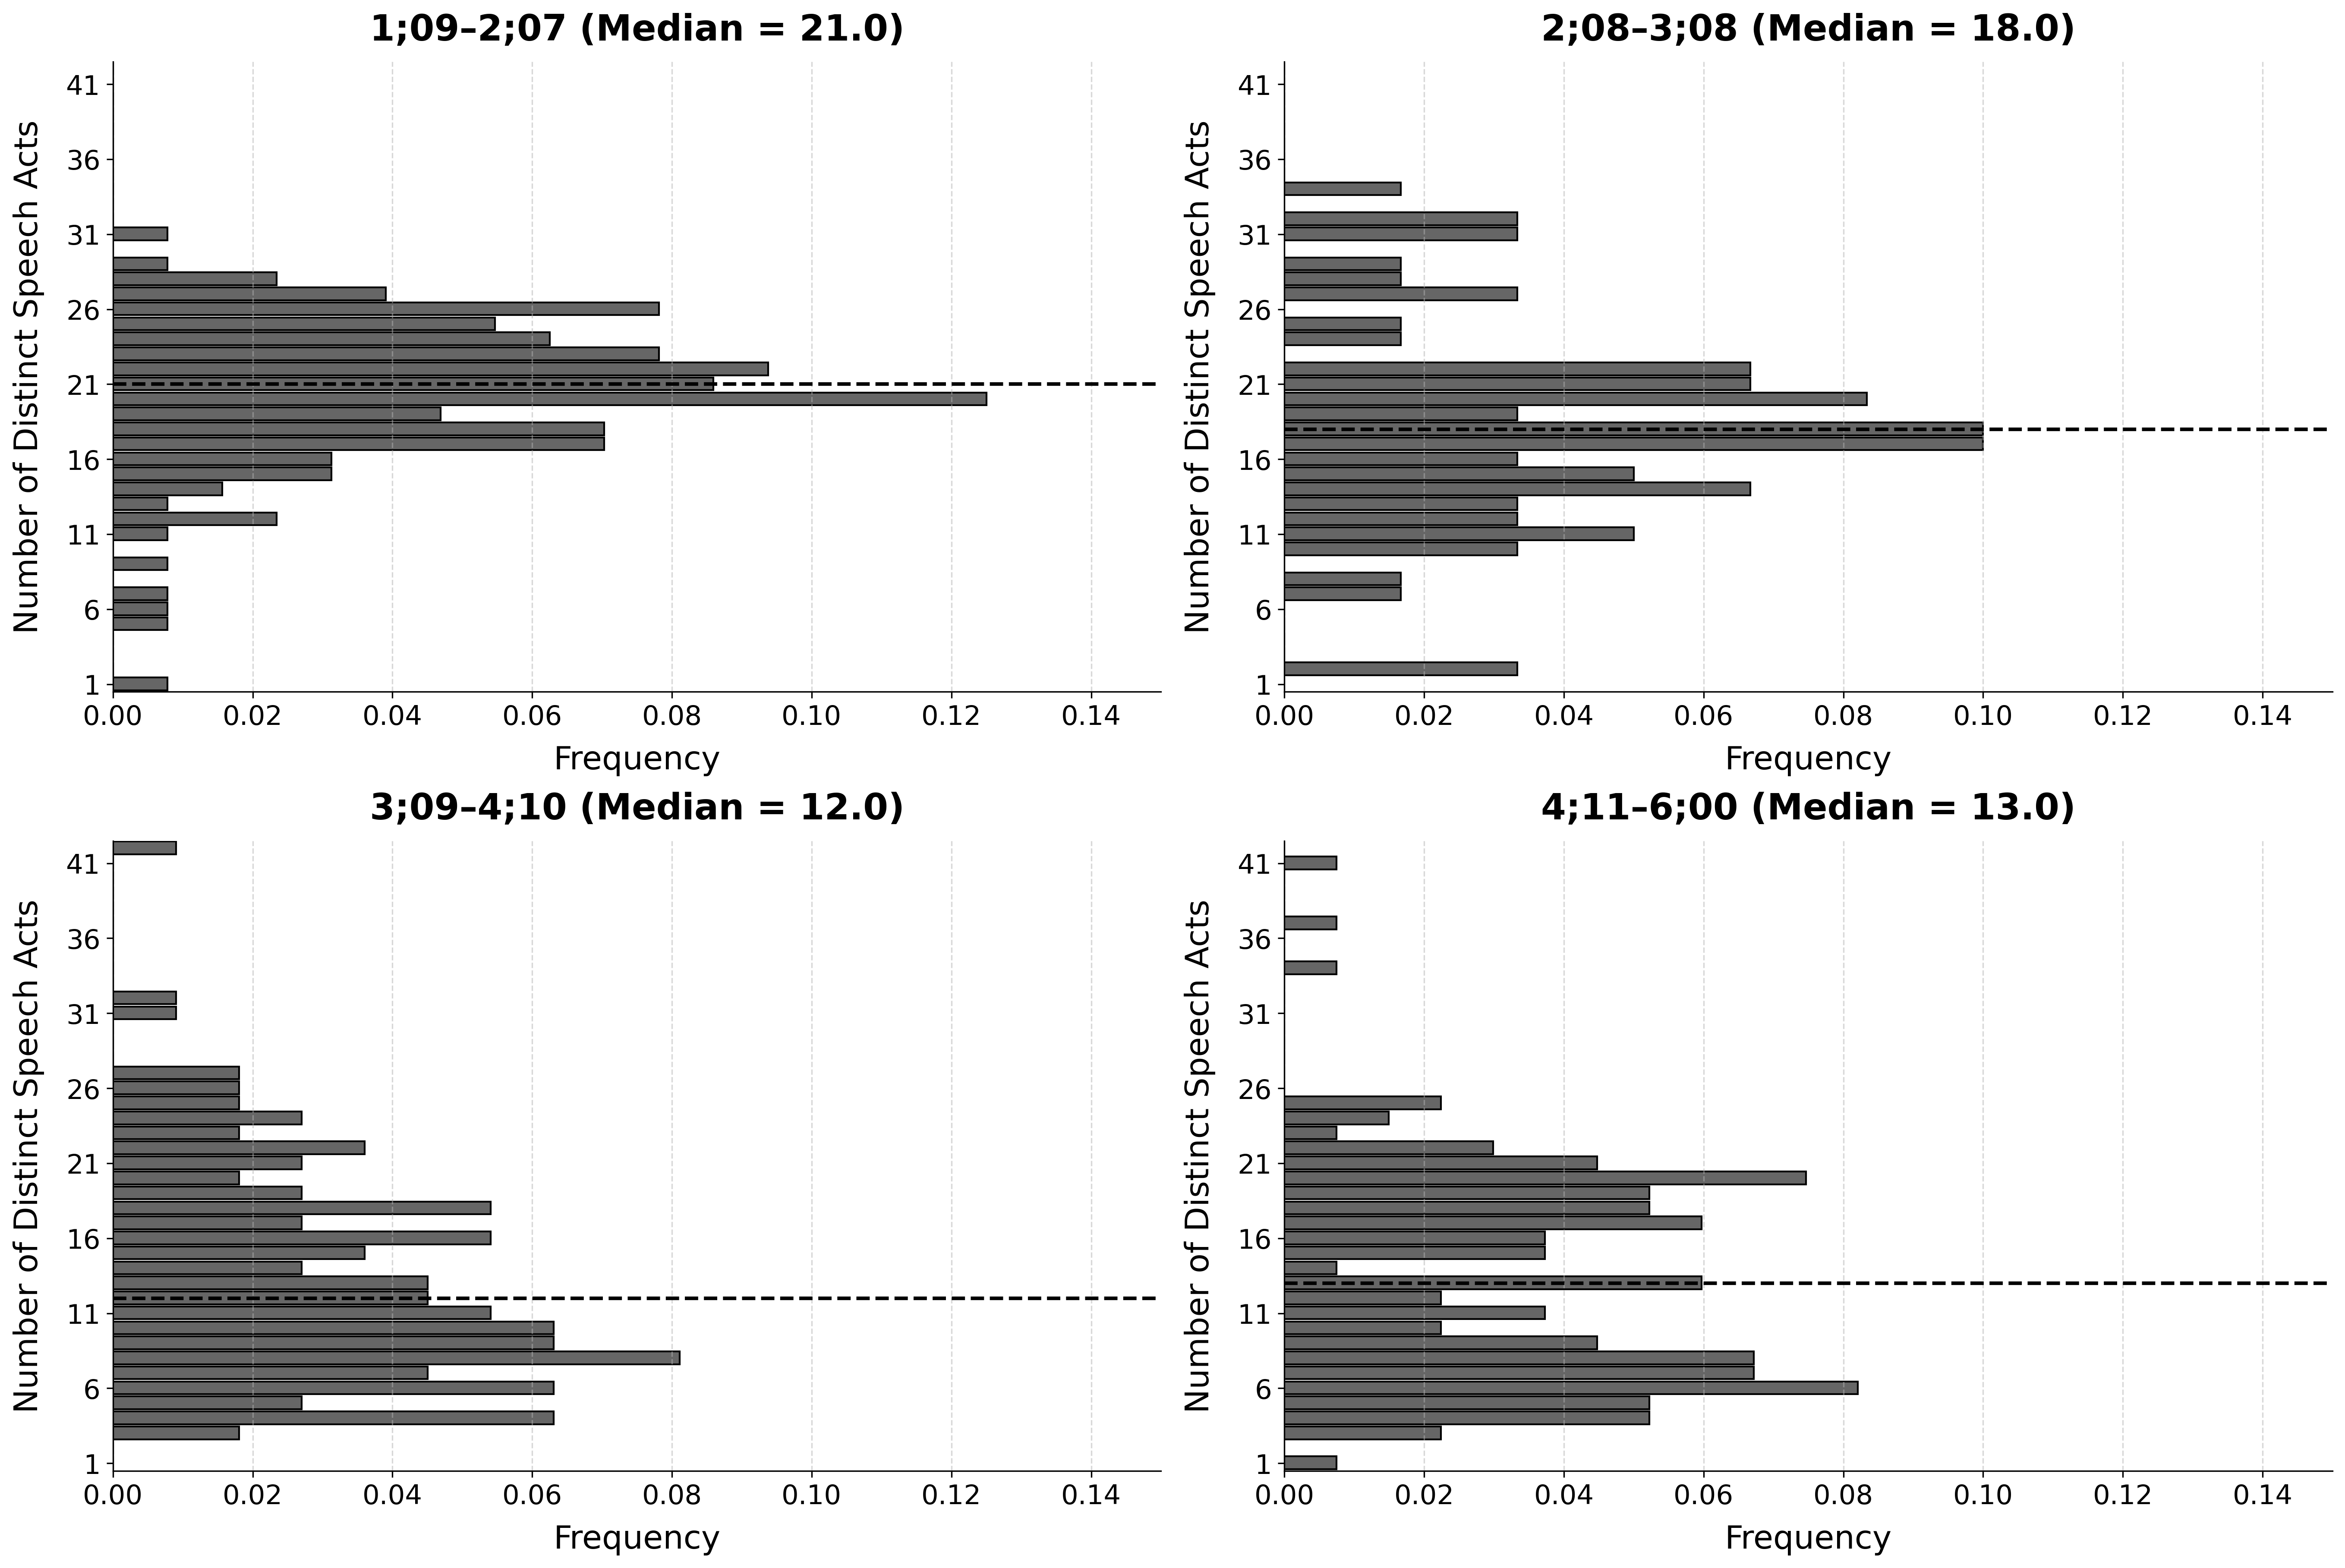

In [60]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams, font_manager

available_fonts = [f.name for f in font_manager.fontManager.ttflist]
rcParams["font.family"] = "Calibri" if "Calibri" in available_fonts else "sans-serif"

plt.rcParams.update({
    "font.size": 16,          # Base text
    "axes.titlesize": 20,     # Panel titles
    "axes.labelsize": 18,     # Axis labels
    "xtick.labelsize": 15,
    "ytick.labelsize": 15,
})

speech_act_columns = speech_act_df.drop(columns=non_speech_act_columns).columns
speech_act_df['distinct_speech_acts'] = (speech_act_df[speech_act_columns] > 0).sum(axis=1)

x_min = int(speech_act_df['distinct_speech_acts'].min())
x_max = int(speech_act_df['distinct_speech_acts'].max())
y_vals_full = np.arange(x_min, x_max + 1)
y_positions = np.arange(len(y_vals_full))

fig, axes = plt.subplots(2, 2, figsize=(18, 12), constrained_layout=True)
axes = axes.flatten()

bucket_labels = ["1;09–2;07", "2;08–3;08", "3;09–4;10", "4;11–6;00"]

# Choose y-tick step dynamically to keep ≤ ~10 ticks visible
max_ticks = 10
n_levels = len(y_vals_full)
ytick_step = max(1, int(np.ceil(n_levels / max_ticks)))
tick_positions = y_positions[::ytick_step]
tick_labels = y_vals_full[::ytick_step]

for bucket in range(4):
    bucket_df = speech_act_df[speech_act_df['assigned_bucket'] == bucket]
    counts = bucket_df['distinct_speech_acts'].value_counts().sort_index()
    proportions = counts / counts.sum()
    bars = proportions.reindex(y_vals_full, fill_value=0)

    ax = axes[bucket]
    bar_container = ax.barh(
        y_positions, bars.values,
        color='0.4',
        edgecolor='black'
    )

    for p in bar_container.patches:
        p.set_height(0.85)


    median_val = bucket_df['distinct_speech_acts'].median()
    median_pos = float(median_val - y_vals_full[0])
    ax.axhline(y=median_pos, color='black', linestyle='--', linewidth=2)

    ax.set_title(f"{bucket_labels[bucket]} (Median = {median_val:.1f})", pad=12, weight='bold')
    ax.set_xlabel("Frequency", labelpad=8)
    ax.set_ylabel("Number of Distinct Speech Acts", labelpad=12)

    ax.set_xlim(0, max(0.15, bars.max() * 1.1))
    ax.set_ylim(-0.5, len(y_vals_full) - 0.5)
    ax.margins(x=0.01, y=0.02)

    # Light gray gridlines on x-axis only (APA style)
    ax.grid(axis='x', linestyle='--', color='0.7', alpha=0.5)
    ax.grid(axis='y', visible=False)

    ax.set_yticks(tick_positions)
    ax.set_yticklabels([str(v) for v in tick_labels])

    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)

plt.savefig("images/Figure 2 - Frequency of distinct speech acts across age groups.png", dpi=600, bbox_inches='tight')
plt.show()

# Clean up
speech_act_df = speech_act_df.drop(columns='distinct_speech_acts')


# Analysing comprehension of speech acts

In the paper: Children's comprehension is inferred when they produce an appropriate speech act in response to an adult’s utterance.

The script pairs each adult utterance with the next child utterance in the same transcript and flags it as contingent if the child's reply matches a valid response from contingent_map. It calculates the proportion of children who have ever made a contingent reply for each speech act (comprehension) and the proportion who have produced each speech act in any context (production). These are merged into `prod_comp_table` for direct comparison of comprehension and production rates by speech act.



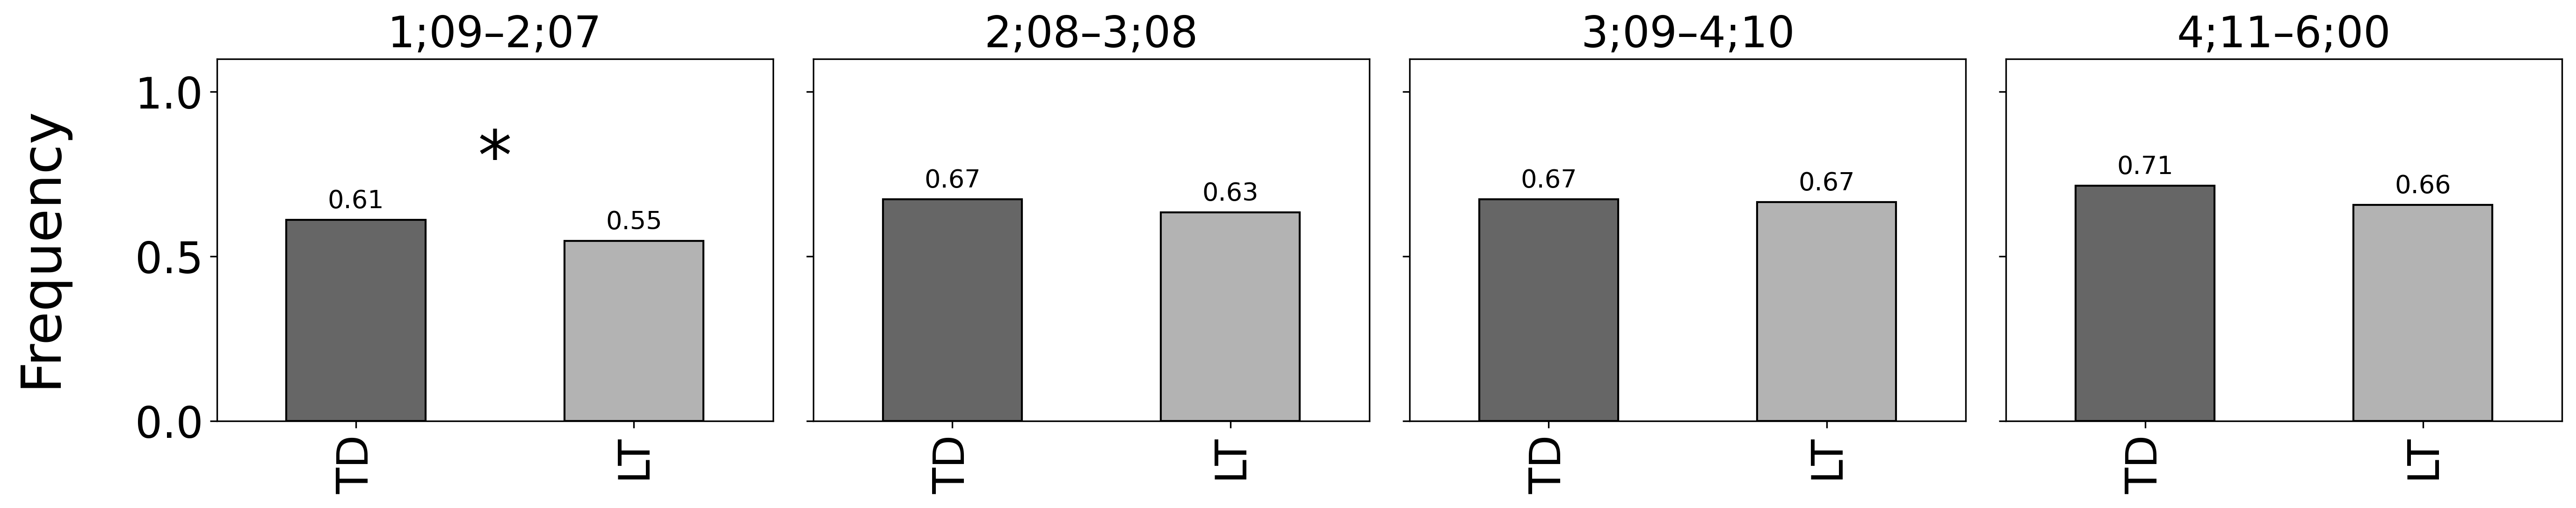

In [61]:
import pandas as pd

comp_data = pd.merge(full_data, all_transcript_map, on='transcript_file', how='inner')

comp_data = (
    comp_data
    .sort_values(['transcript_file', 'utterance_id'])
    .reset_index(drop=True)
)
# Create shifted columns to capture next speaker and their speech act
comp_data['next_speaker'] = comp_data['speaker_code'].shift(-1)
comp_data['next_speech_act'] = comp_data['speech_act'].shift(-1)
comp_data['next_child_id'] = comp_data['child_id'].shift(-1)

# Extract adjacency pairs: where an adult is followed by a child in the same transcript
adj = comp_data[
    (comp_data['speaker_code'] != 'CHI') &
    (comp_data['next_speaker'] == 'CHI') &
    (comp_data['transcript_file'] == comp_data['transcript_file'].shift(-1))
][['age_months', 'speech_act', 'next_speech_act', 'label', 'transcript_file','new_id']].rename(
    columns={
        'speech_act': 'adult_sa',
        'next_speech_act': 'child_sa',
        'next_child_id': 'child_id'
    }
).dropna(subset=['adult_sa', 'child_sa'])

# read the mappings from the csv file and creatae dictionary
contingency_df = pd.read_csv("https://raw.githubusercontent.com/mitjanikolaus/childes-speech-acts/refs/heads/main/adjacency_pairs/adjacency_pairs_contingency.csv")
contingent_map = (
    contingency_df[contingency_df['contingency'] == True]
    .groupby('source')['target']
    .apply(set)
    .to_dict()
)

adj['age_months'] = round(adj['age_months'], 1)

adj = assignBucket(adj).drop(columns='age_months')

# Flag whether each child response is contingent
adj['is_contingent'] = adj.apply(
    lambda r: r['child_sa'] in contingent_map.get(r['adult_sa'], set()),
    axis=1
)


contingent_by_child = (
    adj.groupby(['new_id', 'bucket', 'label'])['is_contingent']
    .mean()
    .reset_index()
    .rename(columns={'is_contingent': 'proportion_contingent'})
)

grouped = (
    contingent_by_child
    .replace({'label': {0: 'TD', 1: 'LT'}})
    .groupby(['bucket', 'label'])['proportion_contingent']
    .mean()
    .unstack()
)

fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharey=True, constrained_layout=False)
bucket_labels = ["1;09–2;07", "2;08–3;08", "3;09–4;10", "4;11–6;00"]

bar_colors = ['0.4', '0.7']  # TD darker, LT lighter
edge_color = 'black'
text_color = 'black'

for i, ax in enumerate(axes):
    if i not in grouped.index:
        ax.set_title(f"{bucket_labels[i]} (No Data)", fontsize=16, color=text_color)
        ax.axis('off')
        continue

    comp_data = grouped.loc[i]

    comp_data = comp_data.reindex(['TD', 'LT'])

    comp_data.plot(
        kind='bar',
        ax=ax,
        color=bar_colors,
        edgecolor=edge_color,
        legend=False
    )

    ax.set_ylim(0, 1.1)
    ax.set_title(f"{bucket_labels[i]}", fontsize=22, color=text_color)
    ax.set_xlabel("", fontsize=14)

    ax.tick_params(axis='x', labelsize=22, colors=text_color)
    ax.tick_params(axis='y', labelsize=22, colors=text_color)

    for j, val in enumerate(comp_data):
        ax.text(j, val + 0.02, f"{val:.2f}", ha='center', va='bottom', fontsize=13, color=text_color)

    if i == 0:
        midpoint = (0 + 1) / 2
        max_val = comp_data.max()
        ax.text(midpoint, max_val + 0.08, '*', ha='center', va='bottom', fontsize=35, color=text_color)

fig.supylabel("Frequency", fontsize=28, x=0.08, color=text_color)

fig.subplots_adjust(left=0.08, top=0.88, bottom=0.10, wspace=0.20)
plt.tight_layout(rect=[0.08, 0.10, 1.00, 0.88])

plt.savefig('images/Figure 5 - Contingent Response frequency across age-groups.png', dpi=300, bbox_inches='tight')
plt.show()


In [62]:
from scipy.stats import ttest_ind
import pandas as pd

stats_results = []

# Iterate over each bucket
for bucket in sorted(contingent_by_child['bucket'].dropna().unique()):
    subset = contingent_by_child[contingent_by_child['bucket'] == bucket]
    td = subset[subset['label'] == 0]['proportion_contingent']
    lt = subset[subset['label'] == 1]['proportion_contingent']

    if len(td) > 0 and len(lt) > 0:
        t_stat, p = ttest_ind(td, lt, equal_var=False, nan_policy='omit')  # Welch’s t-test
        stats_results.append({
            'bucket': bucket,
            'TD_mean': td.mean(),
            'LT_mean': lt.mean(),
            'Number of TD Samples': len(td),
            'Number of LT Samples': len(lt),
            't_statistic': float(f"{t_stat:.4f}"),
            'p_value': float(f"{p:.5f}"),
            'significant': 'Yes' if p < 0.05 else 'No'
        })

# Create DataFrame of results
results_df = pd.DataFrame(stats_results)

print(results_df)


   bucket   TD_mean   LT_mean  Number of TD Samples  Number of LT Samples  \
0       0  0.610743  0.547762                    83                    45   
1       1  0.674277  0.633425                    33                    26   
2       2  0.674074  0.665342                    39                    49   
3       3  0.714973  0.656647                    54                    51   

   t_statistic  p_value significant  
0       3.2429  0.00156         Yes  
1       1.2536  0.21730          No  
2       0.2057  0.83772          No  
3       1.3818  0.17004          No  


In [63]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests

stats_rows = []

# Compute Welch's t-test per bucket
for bucket in sorted(contingent_by_child['bucket'].dropna().unique()):
    sub = contingent_by_child[contingent_by_child['bucket'] == bucket]
    td = sub.loc[sub['label'] == 0, 'proportion_contingent'].astype(float).dropna()
    lt = sub.loc[sub['label'] == 1, 'proportion_contingent'].astype(float).dropna()

    # require at least 2 obs per group to avoid degenerate tests
    if len(td) >= 2 and len(lt) >= 2:
        t_stat, p = ttest_ind(td, lt, equal_var=False, nan_policy='omit')
    else:
        t_stat, p = np.nan, np.nan

    stats_rows.append({
        'bucket': bucket,
        'TD_mean': td.mean() if len(td) else np.nan,
        'LT_mean': lt.mean() if len(lt) else np.nan,
        'TD_n': len(td),
        'LT_n': len(lt),
        't_stat': t_stat,
        'p_raw': p
    })

results_df = pd.DataFrame(stats_rows)

# FDR (Benjamini–Hochberg) across buckets
mask_valid = results_df['p_raw'].notna()
pvals = results_df.loc[mask_valid, 'p_raw'].values
if pvals.size:
    reject, p_adj, *_ = multipletests(pvals, alpha=0.05, method='fdr_bh')
    results_df.loc[mask_valid, 'p_fdr'] = p_adj
    results_df.loc[mask_valid, 'significant_FDR'] = np.where(reject, 'Yes', 'No')
else:
    results_df['p_fdr'] = np.nan
    results_df['significant_FDR'] = np.nan

for _, r in results_df.iterrows():
    t = 'nan' if pd.isna(r['t_stat']) else f"{r['t_stat']:.4f}"
    p = 'nan' if pd.isna(r['p_raw']) else f"{r['p_raw']:.5f}"
    q = 'nan' if pd.isna(r['p_fdr']) else f"{r['p_fdr']:.5f}"
    sig = r.get('significant_FDR', 'No')
    print(f"Bucket {r['bucket']}: t = {t}, p = {p}, q(FDR) = {q}, sig = {sig}")

# Final table
out_cols = ['bucket','TD_mean','LT_mean','TD_n','LT_n','t_stat','p_raw','p_fdr','significant_FDR']
final_df = results_df[out_cols].copy()
final_df[['TD_mean','LT_mean']] = final_df[['TD_mean','LT_mean']].round(4)
final_df[['t_stat','p_raw','p_fdr']] = final_df[['t_stat','p_raw','p_fdr']].round(5)

print("\nFinal Results Table:")
print(final_df)


Bucket 0: t = 3.2429, p = 0.00156, q(FDR) = 0.00624, sig = Yes
Bucket 1: t = 1.2536, p = 0.21730, q(FDR) = 0.28973, sig = No
Bucket 2: t = 0.2057, p = 0.83772, q(FDR) = 0.83772, sig = No
Bucket 3: t = 1.3818, p = 0.17004, q(FDR) = 0.28973, sig = No

Final Results Table:
   bucket  TD_mean  LT_mean  TD_n  LT_n   t_stat    p_raw    p_fdr  \
0       0   0.6107   0.5478    83    45  3.24294  0.00156  0.00624   
1       1   0.6743   0.6334    33    26  1.25364  0.21730  0.28973   
2       2   0.6741   0.6653    39    49  0.20571  0.83772  0.83772   
3       3   0.7150   0.6566    54    51  1.38183  0.17004  0.28973   

  significant_FDR  
0             Yes  
1              No  
2              No  
3              No  


# Adding Linguistic Features

## Phonological neighborhood density (ND)

This block loads the IPhOD word list, builds a lookup table of phonological-neighborhood density (ND) scores, gets the mean ND score for each child.


We used Unstressed Phonological Neighborhood Density(unsDENS) as the neighborhood density value.

 For every child utterance it converts the stored token strings to lists, filters out function words, and collects all remaining content words per child. It then looks up each content word’s ND score, averages those scores to obtain one mean_ND value for each child, and merges that value back into the main full_data DataFrame so the dataset now contains a single phonological feature (mean_ND) for every child.

In [64]:
!gdown "https://drive.google.com/uc?id=1gJfKECkXkUJ5DkDl4UPBvQwnLRmnGCtr"


Downloading...
From: https://drive.google.com/uc?id=1gJfKECkXkUJ5DkDl4UPBvQwnLRmnGCtr
To: /content/IPhOD2_Words.txt
100% 24.0M/24.0M [00:00<00:00, 208MB/s]


In [65]:
import pandas as pd, numpy as np, re, ast
from collections import defaultdict

# load IPhOD (real-word file from IPhODv2.0_REALS.zip)
iphod = pd.read_csv("IPhOD2_Words.txt", sep="\t", engine="python")
iphod["Word"] = iphod["Word"].str.lower()
nd_lookup = dict(zip(iphod["Word"], iphod["unsDENS"]))

# function-word stop-list
function_words = {
    "a","about","above","after","against","all","along","although","among",
    "amongst","an","and","any","anybody","anyone","anything","around","as",
    "at","before","behind","below","beneath","beside","besides","between",
    "beyond","both","but","by","despite","down","during","each","either",
    "every","everybody","everyone","everything","for","from","had","has",
    "have","he","her","here","hers","herself","him","himself","his","how",
    "however","i","if","in","inside","into","is","it","its","itself","just",
    "less","like","many","me","more","most","my","myself","neither","no",
    "nobody","none","nor","nothing","of","off","on","once","one","onto","or",
    "other","others","our","ours","ourselves","out","outside","over","per",
    "several","she","should","since","so","some","somebody","someone",
    "something","that","the","their","theirs","them","themselves","then",
    "there","these","they","this","those","through","till","to","toward",
    "under","underneath","until","up","upon","us","very","was","we","were",
    "what","whatever","when","whenever","where","wherever","which",
    "whichever","who","whoever","whom","whose","why","with","within",
    "without","you","your","yours","yourself","yourselves"
}

# ensure token list
def to_tokens(cell):
    if isinstance(cell, list):
        return cell
    if isinstance(cell, str) and cell.startswith("[") and cell.endswith("]"):
        try:
            return ast.literal_eval(cell)
        except Exception:
            pass
    return [cell]

def content_only(word):
    w = re.sub(r"[^\w']", "", word.lower())
    return w and w not in function_words

# slice child rows and collect content words per child
child_rows = data.copy()
child_rows["content_tokens"] = child_rows["tokens"].apply(
    lambda x: [t for t in map(str.lower, to_tokens(x)) if content_only(t)]
)

collector = defaultdict(list)
for cid, toks in zip(child_rows["new_id"], child_rows["content_tokens"]):
    collector[cid].extend(toks)

# compute mean ND per child
records = []
for cid, words in collector.items():
    vals = [nd_lookup[w] for w in words if w in nd_lookup]
    if vals:
        records.append({"new_id": cid, "mean_ND": np.mean(vals)})

nd_df = pd.DataFrame(records)
# this df will contain additional features than justs speech acts i.e. age, sex, cwf, mlu, nd
speech_act_df_plus = speech_act_df.copy().drop(columns='age_months')
# merge with the main dataframe; this will add a mean_ND column to it
speech_act_df_plus = pd.merge(speech_act_df_plus, nd_df, on='new_id')


## Content word frequency (CWF)
This code converts token strings into lists, filters out function words, and calculates each child’s Content Word Frequency (CWF) as a percentage of total tokens. It then merges the resulting CWF values back into the main `speech_act_df_plus` dataframe for further analysis.

In [66]:
import pandas as pd, numpy as np, ast, re
from collections import defaultdict
import builtins


def to_tokens(x):
    if isinstance(x, list):
        return x
    if isinstance(x, str) and x.startswith("[") and x.endswith("]"):
        try:
            return ast.literal_eval(x)
        except Exception:
            pass
    return [x]

def is_content(t):
    return re.sub(r"[^\w']", "", t.lower()) not in function_words

# child utterances
child_rows = data.copy()
child_rows["token_list"] = child_rows["tokens"].apply(to_tokens)

totals   = defaultdict(int)   # total tokens per child
content  = defaultdict(int)   # non-function tokens per child

for cid, toks in zip(child_rows["new_id"], child_rows["token_list"]):
    totals[cid]  += len(toks)
    content[cid] += builtins.sum(is_content(tok) for tok in toks)

cwf = [
    {"new_id": cid, "CWF": (content[cid] / totals[cid]) * 100}
    for cid in totals if totals[cid] > 0
]
cwf_df = pd.DataFrame(cwf)
# add one CWF value per child to the main table
speech_act_df_plus = pd.merge(speech_act_df_plus, cwf_df, on='new_id')


## Mean length of utterances

This cell calculates the Mean Length of Utterance (MLU) for each child by counting tokens per utterance, averaging them by `new_id`, and merging the resulting MLU values into the main `speech_act_df_plus` dataframe.

In [67]:
import pandas as pd, numpy as np, ast

def to_tokens(x):
    if isinstance(x, list):
        return x
    if isinstance(x, str) and x.startswith("[") and x.endswith("]"):
        try:
            return ast.literal_eval(x)
        except Exception:
            pass
    return [x]

# Get child utterances
child_utterances = data.copy()
child_utterances["token_list"] = child_utterances["tokens"].apply(to_tokens)

# Count tokens per utterance
child_utterances["utterance_len"] = child_utterances["token_list"].apply(len)

# Compute mean length per child
mlu_df = (
    child_utterances
      .groupby("new_id")["utterance_len"]
      .mean()
      .reset_index()
      .rename(columns={"utterance_len": "MLU"})
)

#merge with main df
speech_act_df_plus = pd.merge(speech_act_df_plus, mlu_df, on='new_id')


## Classification with speech acts + linguistic features + sex + age group


In [68]:

X = speech_act_df_plus.drop(columns=['label', 'new_id'])
y = speech_act_df_plus['label']
X = pd.DataFrame(normalize(X), columns=X.columns)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Define classifiers
models = {
    'SVM': SVC(),
    'KNN': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier()
}
models["SVM"] = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", SVC())
])


### Cross validation

In [69]:
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

# Define custom scorers to avoid warnings
f1 = make_scorer(f1_score, zero_division=0)
precision = make_scorer(precision_score, zero_division=0)
recall = make_scorer(recall_score, zero_division=0)

# Prepare list for storing results
cv_results = []

# Loop through models
for name, model in models.items():
    acc = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
    f1_scores = cross_val_score(model, X, y, cv=cv, scoring=f1)
    prec_scores = cross_val_score(model, X, y, cv=cv, scoring=precision)
    rec_scores = cross_val_score(model, X, y, cv=cv, scoring=recall)

    cv_results.append({
        'Model': name,
        'Accuracy': round(acc.mean(), 3),
        'F1 Score': round(f1_scores.mean(), 3),
        'Precision': round(prec_scores.mean(), 3),
        'Recall': round(rec_scores.mean(), 3),
        'Accuracy Std': round(acc.std(), 3)
    })

# Create DataFrame
cv_df = pd.DataFrame(cv_results)
cv_df_sorted = cv_df.sort_values(by='F1 Score', ascending=False).reset_index(drop=True)
X.drop(columns='target_child_sex')
cv_df_sorted.to_excel("tables/cv_with_linguistic_features.xlsx", index=False)
print(cv_df_sorted)


           Model  Accuracy  F1 Score  Precision  Recall  Accuracy Std
0        XGBoost     0.738     0.663      0.689   0.642         0.032
1            KNN     0.722     0.640      0.665   0.618         0.039
2  Random Forest     0.720     0.611      0.681   0.560         0.034
3            SVM     0.722     0.610      0.692   0.554         0.025
4  Decision Tree     0.683     0.608      0.609   0.584         0.044
5    Naive Bayes     0.630     0.465      0.545   0.410         0.027


### Hyperparameter tuning of XGBoost

In [70]:
xgb = models['XGBoost']

# Parameter grid for XGBoost
param_dist = {
    'n_estimators': [int(x) for x in np.linspace(100, 1000, 10)],
    'max_depth': [3, 5, 7, 10, 15],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.3, 0.5],
    'min_child_weight': [1, 3, 5]
}

cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

# Define  metrics
scoring = {
    'accuracy': 'accuracy',
    'f1': 'f1',
    'precision': 'precision',
    'recall': 'recall'
}

random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=50,
    scoring=scoring,
    refit='accuracy',
    cv=cv,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X, y)
best_xgb = random_search.best_estimator_
models['XGBoost'] = best_xgb

# Output best parameters and CV metrics
print("Best XGBoost Parameters:")
print(random_search.best_params_)

mean_test_acc = random_search.cv_results_['mean_test_accuracy'][random_search.best_index_]
mean_test_f1 = random_search.cv_results_['mean_test_f1'][random_search.best_index_]
mean_test_prec = random_search.cv_results_['mean_test_precision'][random_search.best_index_]
mean_test_rec = random_search.cv_results_['mean_test_recall'][random_search.best_index_]

print(f"Best CV Accuracy:  {mean_test_acc:.4f}")
print(f"Best CV F1 Score:  {mean_test_f1:.4f}")
print(f"Best CV Precision: {mean_test_prec:.4f}")
print(f"Best CV Recall:    {mean_test_rec:.4f}")


Fitting 4 folds for each of 50 candidates, totalling 200 fits
Best XGBoost Parameters:
{'subsample': 0.8, 'n_estimators': 300, 'min_child_weight': 1, 'max_depth': 10, 'learning_rate': 0.2, 'gamma': 0.1, 'colsample_bytree': 0.8}
Best CV Accuracy:  0.7662
Best CV F1 Score:  0.7032
Best CV Precision: 0.7213
Best CV Recall:    0.6880


Most important features for XGBoost

Gain measures average improvement in loss from splits using a feature

In [71]:
import pandas as pd
import matplotlib.pyplot as plt

importances = best_xgb.get_booster().get_score(importance_type='gain')

# Map to column names (X must be DataFrame)
feat_importance = (
    pd.DataFrame({
        'feature': list(importances.keys()),
        'importance': list(importances.values())
    })
    .sort_values('importance', ascending=False)
)

print(feat_importance.head(20))
feat_importance.to_csv('XGBoost_feature_importance.csv', index=False)


             feature  importance
35                TQ    2.551688
44               MLU    2.488256
31                SS    2.175955
32                ST    1.970356
6                 CN    1.905775
5                 CL    1.888439
14                FP    1.688169
2                 AD    1.516729
40   assigned_bucket    1.462070
25                RQ    1.458037
22                QN    1.451335
30                SI    1.356783
26                RR    1.276447
18                PA    1.248529
43               CWF    1.205224
42           mean_ND    1.125804
27                RT    1.125008
41  target_child_sex    1.074657
10                DS    1.042903
4                 AP    1.005042


### ROC and AUC for XGBoost

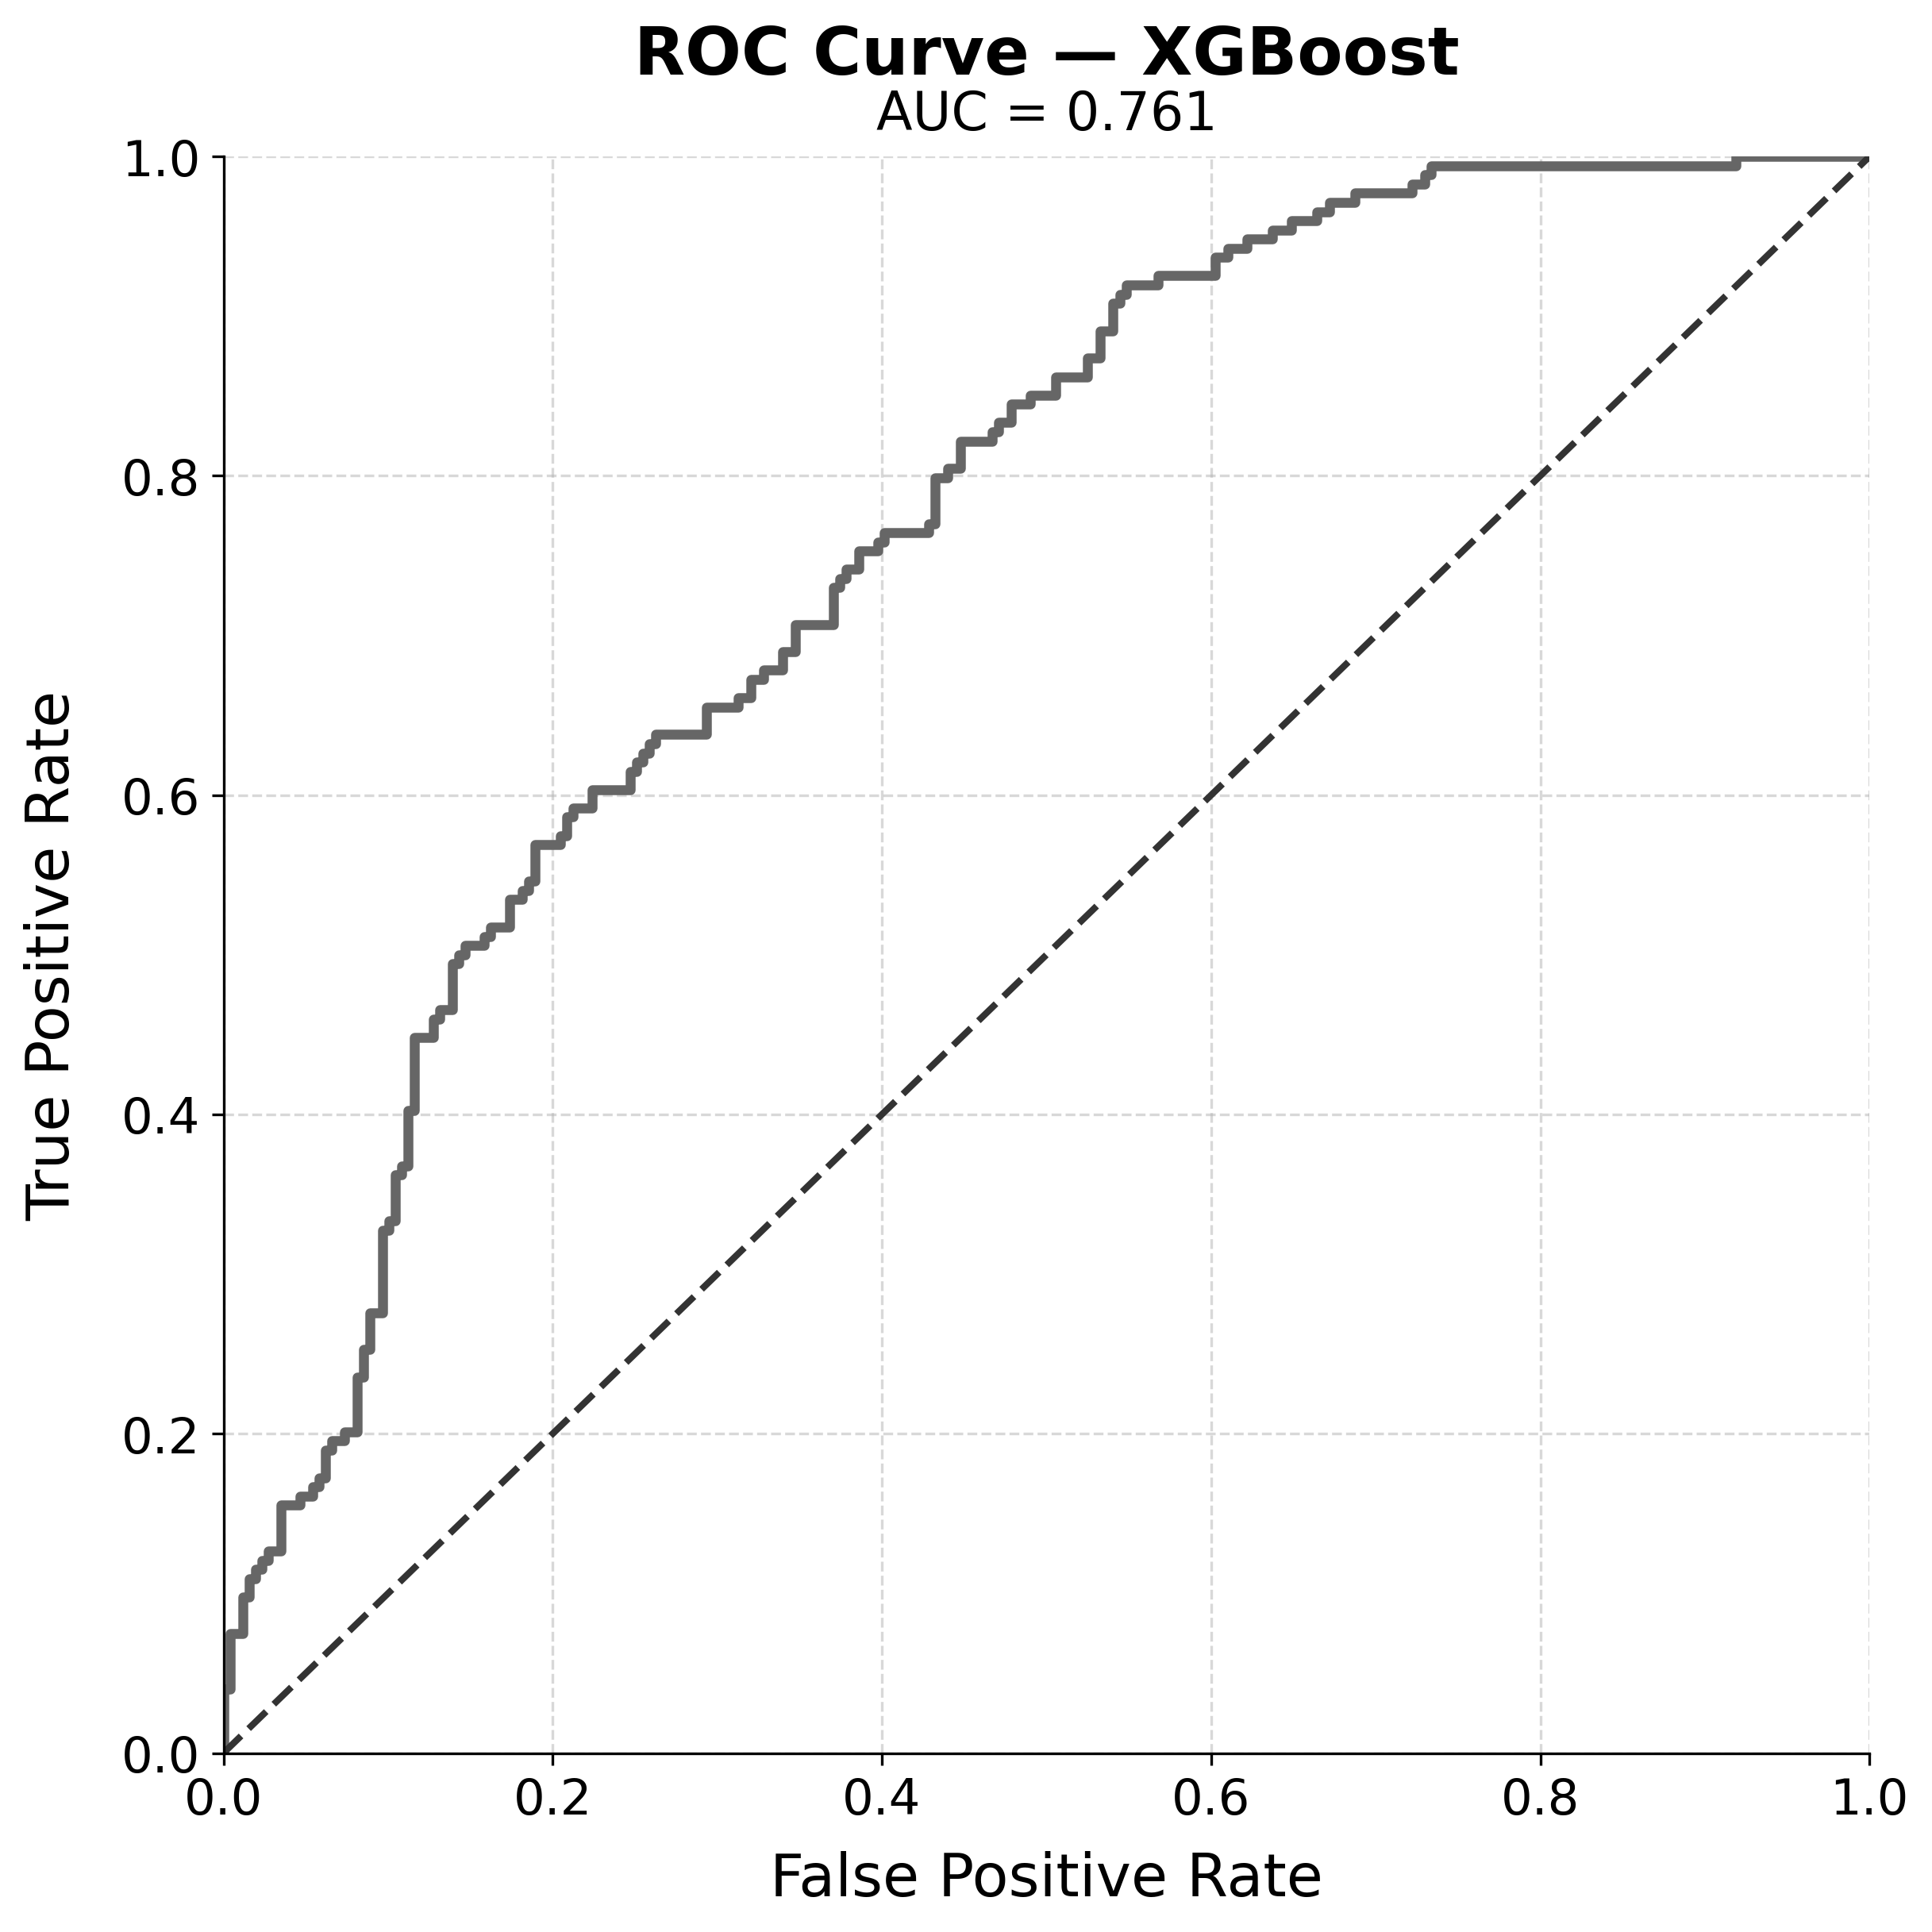

XGBoost CV ROC AUC (OOF): 0.7615


In [72]:
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import normalize
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import font_manager, rcParams

# --- Features / labels (match your pipeline) ---
X = speech_act_df.drop(columns=non_speech_act_columns)
y = speech_act_df["label"]

# Normalize speech act features
X = pd.DataFrame(normalize(X), columns=X.columns)

# --- Plot styling (match your other plots) ---
available_fonts = [f.name for f in font_manager.fontManager.ttflist]
rcParams["font.family"] = "Calibri" if "Calibri" in available_fonts else "sans-serif"

plt.rcParams.update({
    "font.size": 16,
    "axes.titlesize": 20,
    "axes.labelsize": 18,
    "xtick.labelsize": 15,
    "ytick.labelsize": 15,
})

# --- CV definition (same as your tuning) ---
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

# --- Use your tuned XGBoost model ---
xgb = models["XGBoost"]   # this should be best_xgb after RandomizedSearchCV

# Out-of-fold probabilities for the positive class
y_prob = cross_val_predict(xgb, X, y, cv=cv, method="predict_proba", n_jobs=-1)[:, 1]

# ROC + AUC
fpr, tpr, _ = roc_curve(y, y_prob)
roc_auc = auc(fpr, tpr)

# --- Plot ROC ---
fig, ax = plt.subplots(figsize=(8, 8), constrained_layout=True)

ax.plot(fpr, tpr, color="0.4", linewidth=3)
ax.plot([0, 1], [0, 1], linestyle="--", color="0.2", linewidth=2)

ax.set_title("ROC Curve — XGBoost", pad=25, weight="bold")
ax.text(
    0.5, 1.01,
    f"AUC = {roc_auc:.3f}",
    transform=ax.transAxes,
    ha="center",
    va="bottom",
    fontsize=16
)

ax.set_xlabel("False Positive Rate", labelpad=8)
ax.set_ylabel("True Positive Rate", labelpad=12)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

ax.grid(axis="both", linestyle="--", color="0.7", alpha=0.5)
for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)

plt.savefig("images/Figure 4 - XGB ROC.png", dpi=600, bbox_inches="tight")
plt.show()

print(f"XGBoost CV ROC AUC (OOF): {roc_auc:.4f}")
